# Converting each MOF to a graph
* reads in each MOF from DDEC charge-assigned dataset
* infers bonds using distance-based criterion
* writes to file: 
    * list of crystal names: `list_of_crystals.txt`
    * node features: `graphs/xtalname_node_features.npy`
    * edge list and features: `graphs/xtalname.edge_info`. the edges are 0-based indexed.
    * node labels (charges): `graphs/xtalname_node_labels.npy`
    * location of atom types in one-hot-encoding: `atom_to_int.csv`

In [1]:
using PorousMaterials # use major_refactor branch.
using DataFrames
using PyPlot
using NPZ
using CSV
using LightGraphs
using LinearAlgebra
using Logging
using Printf
using DelimitedFiles
using ProgressMeter
using PyCall
push!(LOAD_PATH, pwd()) # to see Bonds.jl
using Bonds
using Statistics

# global_logger(Logging.SimpleLogger(stdout, Logging.Info)) # to print @debug put Logging.Debug
global_logger(Logging.SimpleLogger(stdout, Logging.Debug)) # to print @debug put Logging.Debug

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(0x0000002e) open, 0 bytes waiting))), Info, Dict{Any,Int64}())

### get list of MOFs
MOF `.cif` files with DDEC-assigned charges are found in `xtals/`. These were downloaded from [here](https://github.com/gregchung/gregchung.github.io/blob/master/CoRE-MOFs/core-mof-1.0-ddec.tar). The paper corresponding to these structures is [here](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.5b03836).

In [48]:
@eval PorousMaterials PATH_TO_CRYSTALS = joinpath(pwd(), "ddec_xtals")

"/home/sturlusa/my_projects/scratch/mpn_charges/build_graphs/ddec_xtals"

In [49]:
xtalnames = map(x -> replace(x, ".cif" => ""), readdir("ddec_xtals"))

2932-element Array{String,1}:
 "ABAVIJ_clean"
 "ABAVOP_clean"
 "ABEXIQ_clean"
 "ABEXOW_clean"
 "ABEXUC_clean"
 "ABEYAJ_clean"
 "ABEYIR"
 "ABIYIV"
 "ABUWOJ_clean"
 "ACAKUM"
 "ACALIB_clean"
 "ACODED"
 "ACOLIP_clean"
 ⋮
 "ZILBAZ_clean"
 "ZILBED_clean"
 "ZIMJOW_clean"
 "ZISYAD_clean"
 "ZNGLUD01_clean"
 "ZNGLUD_clean"
 "ZURQOS_clean"
 "Zn-DOBDC"
 "ZnBDC"
 "ZnBDCdabco"
 "ZnHBDC"
 "ZnMOF-74"

### Lets remove duplicate structures from the data set.

`duplicates.csv` is a table from Nazarian et al. (DOI: 10.1021/acs.chemmater.5b03836) </br>
Each row contains the names of different `.cif` files of the same structure in the CoRE dataset. </br>
We'll start by cross-referencing the structures in the DDEC dataset with the first column in `duplicates.csv`

In [4]:
all_structures = CSV.read("duplicates.csv")
unique_structures = all_structures[:,1]

4297-element WeakRefStrings.StringArray{String,1}:
 "Cu-BTC"
 "EDUSIF_clean"
 "CIWRAC_clean"
 "GIKMOD01_clean"
 "FIQYOU_clean"
 "ITIWIS_charged"
 "ATIBAG_clean"
 "OKITIM01_charged"
 "FARFIO_clean"
 "IDIWOH"
 "FIJDIM01_clean"
 "MECWEX_manual"
 "BAHGUN01_clean"
 ⋮
 "FALQIU_clean"
 "WAMRIN02_clean"
 "OVEJIJ_clean"
 "UNABIV_charged"
 "ZIF-97"
 "WAWGOQ_clean"
 "IZEPAF_clean"
 "ZIF-93"
 "SAPJEA_charged"
 "DEYNIG_clean"
 "GAHWIX_clean"
 "WENSIS_clean"

In [5]:
set_of_unique_xtals = Set(unique_structures)
set_of_ddec_xtals = Set(xtalnames)
set_of_unique_ddec_xtals = intersect(set_of_unique_xtals, set_of_ddec_xtals)
length(set_of_unique_ddec_xtals)

2285

In some cases, rather than the structure in the first column of `duplicates.csv`, other structures are included in the DDEC dataset. </br>
The following code is used to see if there are other unique structures in the DDEC dataset that were not in the first column of `duplicates.csv`

In [6]:
for (i, unique_xtal) in enumerate(unique_structures)
    if ! in(unique_xtal, set_of_ddec_xtals)
        other_xtals = all_structures[i, 2:end]
        if length(intersect(set_of_ddec_xtals, Set(other_xtals))) > 0
            have_i_added_another_crystal = false
            @warn @sprintf("%s is not in the DDEC set but...\n", unique_xtal)
            for (j, duplicate_xtal) in enumerate(other_xtals)
                if ismissing(duplicate_xtal)
                    break
                end
                if duplicate_xtal in xtalnames
                    if ! have_i_added_another_crystal
                        push!(set_of_unique_ddec_xtals, duplicate_xtal)
                        have_i_added_another_crystal = true
                    end
                    @printf("\t%s is in the set\n", duplicate_xtal)
                end
            end
        end
    end
end

┌ Warning: Cu-BTC is not in the DDEC set but...
└ @ Main In[6]:6
	DOTSOV02_clean is in the set
	DOTSOV03_clean is in the set
	DOTSOV04_clean is in the set
	DOTSOV05_clean is in the set
	DOTSOV06_clean is in the set
	DOTSOV07_clean is in the set
	DOTSOV08_clean is in the set
	DOTSOV09_clean is in the set
	DOTSOV10_clean is in the set
	DOTSOV11_clean is in the set
	DOTSOV12_clean is in the set
	DOTSOV13_clean is in the set
	DOTSOV14_clean is in the set
	DOTSOV15_clean is in the set
	DOTSOV16_clean is in the set
	DOTSOV18_clean is in the set
	DOTSOV19_clean is in the set
	DOTSOV20_clean is in the set
	DOTSOV21_clean is in the set
	DOTSOV22_clean is in the set
	DOTSOV23_clean is in the set
	DOTSOV24_clean is in the set
	DOTSOV25_clean is in the set
	DOTSOV26_clean is in the set
	DOTSOV27_clean is in the set
	DOTSOV28_clean is in the set
	DOTSOV29_clean is in the set
	DOTSOV30_clean is in the set
	DOTSOV31_clean is in the set
	DOTSOV32_clean is in the set
	DOTSOV33_clean is in the set
	DOTS

In [7]:
xtalnames = collect(set_of_unique_ddec_xtals)
@show length(xtalnames);

length(xtalnames) = 2325


### find unique atomic species

In [8]:
unique_atomic_species = Set{Symbol}()

for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif")
    for a in unique(crystal.atoms.species)
        push!(unique_atomic_species, a)
    end
end
unique_atomic_species

println("# unique atomic species: ", length(unique_atomic_species))

# unique atomic species: 74


### analyze occurance of atomic species in MOFs
i.e., how many MOFs contain atom $i$? this is important to ensure we can adequately learn charges on rare MOF atoms.

In [9]:
species_occurance = Dict{Symbol, Int}(a => 0 for a in unique_atomic_species)
for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif")
    for a in unique(crystal.atoms.species)
        species_occurance[a] += 1
    end
end
species_occurance

Dict{Symbol,Int64} with 74 entries:
  :Cl => 70
  :Al => 19
  :Be => 2
  :Re => 5
  :Cr => 16
  :Na => 36
  :Sb => 2
  :Ni => 111
  :S  => 179
  :Ru => 10
  :Tm => 17
  :W  => 14
  :Nd => 78
  :O  => 2050
  :Th => 4
  :F  => 69
  :Co => 237
  :Gd => 64
  :Rh => 2
  :Pu => 1
  :Ca => 39
  :N  => 1472
  :Yb => 25
  :As => 2
  :Se => 1
  ⋮   => ⋮

put in a `DataFrame` for sorting and plotting

In [10]:
df_species_occurance = DataFrame(atom=collect(keys(species_occurance)), 
                                 nb_mofs=collect(values(species_occurance))
                                 )
sort!(df_species_occurance, :nb_mofs)
first(df_species_occurance, 6)

,atom,nb_mofs
,Symbol,Int64
1,Pu,1
2,Se,1
3,Hf,1
4,Ir,1
5,Be,2
6,Sb,2


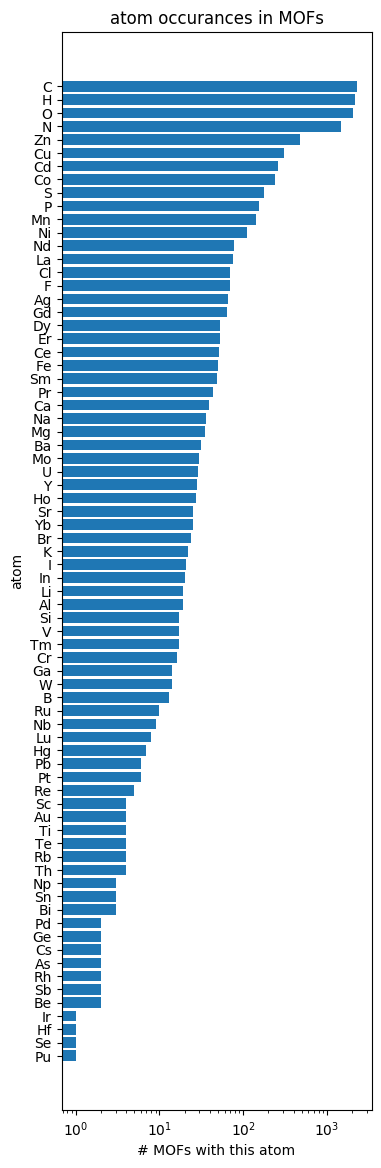

PyObject Text(0.5, 1, 'atom occurances in MOFs')

In [11]:
figure(figsize=(4, 14))
barh(1:nrow(df_species_occurance), df_species_occurance[:, :nb_mofs])
yticks(1:nrow(df_species_occurance), df_species_occurance[:, :atom])
xlabel("# MOFs with this atom")
ylabel("atom")
xscale("log")
title("atom occurances in MOFs")

### atom <--> integer mapping for one-hot encoding

sort my occurance

In [12]:
sort!(df_species_occurance, :nb_mofs, rev=true)
const ATOMS = deepcopy(df_species_occurance[:, :atom])
ATOMS

74-element Array{Symbol,1}:
 :C
 :H
 :O
 :N
 :Zn
 :Cu
 :Cd
 :Co
 :S
 :P
 :Mn
 :Ni
 :Nd
 ⋮
 :Np
 :Be
 :Sb
 :Rh
 :As
 :Cs
 :Ge
 :Pd
 :Pu
 :Se
 :Hf
 :Ir

In [13]:
const ATOM_TO_INT = Dict{Symbol, Int}(a => i for (i, a) in enumerate(ATOMS))
ATOM_TO_INT

Dict{Symbol,Int64} with 74 entries:
  :Cl => 15
  :Al => 39
  :Re => 54
  :Be => 64
  :Cr => 44
  :Na => 26
  :Sb => 65
  :Ni => 12
  :S  => 9
  :Ru => 48
  :Tm => 41
  :W  => 45
  :Nd => 13
  :O  => 3
  :Th => 55
  :F  => 16
  :Co => 8
  :Gd => 18
  :Rh => 66
  :Pu => 71
  :Ca => 25
  :N  => 4
  :Yb => 33
  :As => 67
  :Se => 72
  ⋮   => ⋮

In [47]:
CSV.write(joinpath("..", "atom_to_int.csv"), ATOM_TO_INT)

"../atom_to_int.csv"

### Lets analyze the charges of the DDEC set real quick

In [15]:
charge_list = Dict(atom => Float64[] for atom in keys(ATOM_TO_INT))

for (i_xtal, xtalname) in enumerate(xtalnames)
    xtal = Crystal(xtalname * ".cif", include_zero_charges=true)
    for (j, atom) in enumerate(xtal.atoms.species)
        append!(charge_list[atom], xtal.charges.q[j])
    end
end

In [16]:
atoms = []
σ = []
for x in keys(charge_list)
    push!(atoms, x)
    push!(σ, std(charge_list[x]))
end
stdev_df = DataFrame(Dict(:element => atoms, :stdev => σ))
CSV.write("stdev.csv", stdev_df)

"stdev.csv"

In [17]:
INT_TO_ATOM = Dict(value => key for (key, value) in ATOM_TO_INT)
mean_charges = zeros(length(charge_list))
for i = 1:74
    mean_charges[i] = mean(charge_list[INT_TO_ATOM[i]])
end

In [18]:
mean_charge_df = DataFrame(:mean_charge => mean_charges, :atom => [INT_TO_ATOM[i] for i = 1:74])

,mean_charge,atom
,Float64,Symbol
1,0.0909217,C
2,0.117561,H
3,-0.63384,O
4,-0.303676,N
5,0.940772,Zn
6,0.665301,Cu
7,0.956287,Cd
8,0.933813,Co
9,0.329906,S


In [19]:
mean_charge_dict = Dict()
for row in 1:size(mean_charge_df)[1]
    mean_charge_dict[Symbol(mean_charge_df[!, :atom][row])] = mean_charge_df[!, :mean_charge][row]
end

In [20]:
CSV.write("mean_charges.csv", mean_charge_df)

"mean_charges.csv"

In [21]:
variance_list = Dict([atom => std(charge_list[atom])^2 for atom in keys(charge_list)])

Dict{Symbol,Float64} with 74 entries:
  :Cl => 0.129235
  :Al => 0.0146457
  :Re => 0.0251067
  :Be => 0.000206268
  :Cr => 0.275067
  :Na => 0.00402325
  :Sb => 0.105673
  :Ni => 0.0899525
  :S  => 0.492286
  :Ru => 0.204149
  :Tm => 0.00534872
  :W  => 0.72736
  :Nd => 0.0187538
  :O  => 0.0197265
  :Th => 0.0427729
  :F  => 0.0230854
  :Co => 0.0509429
  :Gd => 0.00800505
  :Rh => 0.113852
  :Pu => 8.025e-11
  :Ca => 0.00289059
  :N  => 0.0482406
  :Yb => 0.0152861
  :As => 0.514185
  :Se => 0.000149378
  ⋮   => ⋮

In [22]:
AD = []

@showprogress for (i_xtal, xtalname) in enumerate(xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    new_charge_list = [mean_charge_dict[atom] for atom in crystal.atoms.species]
    variances = [variance_list[atom] for atom in crystal.atoms.species]
    weights = variances ./ sum(variances)
    net_charge = sum(new_charge_list)
    new_charge_list = new_charge_list - net_charge.*weights
    for i in 1:length(new_charge_list)
        push!(AD, abs(new_charge_list[i] - crystal.charges.q[i]))
    end
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


In [23]:
sum(AD)/length(AD)

0.14775732151772583

### write graph structure, edge features, node features, and node labels to file for each MOF

In [24]:
isdir("graphs") ? nothing : mkdir("graphs")

In [25]:
@info "making edge list zero-based indexed for Python"

keep_xtal = [true for i = 1:length(xtalnames)]

@showprogress for (i_xtal, xtalname) in enumerate(xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
        else
            error("bond! error for " * crystal.name)
        end
    end
    @assert nv(crystal.bonds) == crystal.atoms.n
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    ###
    #    node features
    #    one-hot encoding. each row is an atom.
    ###
    x_ν = zeros(Int, crystal.atoms.n, length(ATOMS))
    for (i, atom) in enumerate(crystal.atoms.species)
        x_ν[i, ATOM_TO_INT[atom]] = 1
    end
    @assert sum(x_ν) == crystal.atoms.n
    npzwrite(joinpath("graphs", xtalname * "_node_features.npy"), x_ν)

    ###
    #    node labels (the charges)
    ###
    y_ν = deepcopy(crystal.charges.q)
    npzwrite(joinpath("graphs", xtalname * "_node_labels.npy"), y_ν)
    @assert length(y_ν) == size(x_ν)[1]

    ###
    #   edges
    #   (a list and their feature = distance btwn atoms)
    ###
    edge_file = open(joinpath("graphs", xtalname * ".edge_info"), "w")
    @printf(edge_file, "src,dst,r\n")
    for ed in edges(crystal.bonds)
        i = src(ed) # source
        j = dst(ed) # destination
        r = distance(crystal.atoms, crystal.box, i, j, true)
        @printf(edge_file, "%d,%d,%f\n", i - 1, j - 1, r)
    end
    close(edge_file)
end

writedlm(open("list_of_crystals.txt", "w"), xtalnames[keep_xtal])

┌ Info: making edge list zero-based indexed for Python
└ @ Main In[25]:1


Progress:   4%|█▋                                       |  ETA: 0:08:57

┌ Warning: hydrogen atom 18 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 20 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 22 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 26 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:   4%|█▊                                       |  ETA: 0:08:54

┌ Warning: hydrogen atom 31 in BORBEQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 64 in BORBEQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 97 in BORBEQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 130 in BORBEQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = BORBEQ_clean.cif
└ @ Main In[25]:23


Progress:   6%|██▋                                      |  ETA: 0:07:56

┌ Warning: hydrogen atom 10 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 38 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 52 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = BONWIL_clean.cif
└ @ Main In[25]:23


Progress:   7%|██▊                                      |  ETA: 0:07:58

┌ Warning: carbon atom 102 in KOJZAL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 106 in KOJZAL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 138 in KOJZAL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 142 in KOJZAL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = KOJZAL_clean.cif
└ @ Main In[25]:23


Progress:   9%|███▊                                     |  ETA: 0:07:36

┌ Warning: hydrogen atom 8 in ISEQIH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in ISEQIH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ISEQIH_clean.cif
└ @ Main In[25]:23


Progress:  11%|████▌                                    |  ETA: 0:07:46

┌ Warning: hydrogen atom 14 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 16 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 26 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FAZZEM_clean.cif
└ @ Main In[25]:23


Progress:  13%|█████▎                                   |  ETA: 0:07:34

┌ Warning: hydrogen atom 17 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 20 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 29 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 30 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  14%|█████▌                                   |  ETA: 0:07:40

┌ Warning: hydrogen atom 28 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 68 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 88 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = XAWZOM_clean.cif
└ @ Main In[25]:23


Progress:  16%|██████▋                                  |  ETA: 0:07:24

┌ Warning: carbon atom 29 in MOGXUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 36 in MOGXUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 43 in MOGXUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 50 in MOGXUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 57 in MOGXUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 64 in MOGXUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbo

Progress:  20%|████████▎                                |  ETA: 0:07:16

Voronoi problems with HAFTOZ_clean.cif
┌ Warning: atom 1 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warni

Progress:  21%|████████▌                                |  ETA: 0:07:11

┌ Warning: carbon atom 109 in NATXOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 110 in NATXOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 111 in NATXOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 134 in NATXOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 135 in NATXOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 136 in NATXOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  21%|████████▊                                |  ETA: 0:07:04

┌ Warning: hydrogen atom 5 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 8 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 10 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 37 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwin

Progress:  23%|█████████▎                               |  ETA: 0:06:59

Voronoi problems with COF-5.cif


Progress:  24%|█████████▊                               |  ETA: 0:06:53

Voronoi problems with QUQPOI_clean.cif
┌ Warning: atom 1 = Zn in QUQPOI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = QUQPOI_clean.cif
└ @ Main In[25]:23


Progress:  26%|██████████▌                              |  ETA: 0:06:41

┌ Warning: hydrogen atom 14 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 15 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 25 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 34 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  26%|██████████▋                              |  ETA: 0:06:38

┌ Warning: hydrogen atom 6 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 7 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 8 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 31 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 33 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing

Progress:  28%|███████████▌                             |  ETA: 0:06:29

┌ Warning: hydrogen atom 9 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 10 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 16 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 17 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 23 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrog

Progress:  35%|██████████████▌                          |  ETA: 0:05:47

┌ Warning: hydrogen atom 10 in SUHHOT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = SUHHOT_clean.cif
└ @ Main In[25]:23


Progress:  38%|███████████████▊                         |  ETA: 0:05:29

┌ Warning: hydrogen atom 16 in UJARAZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in UJARAZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = UJARAZ_clean.cif
└ @ Main In[25]:23


Progress:  42%|█████████████████▏                       |  ETA: 0:05:06

┌ Warning: carbon atom 89 in HITXUE.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 90 in HITXUE.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 91 in HITXUE.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 92 in HITXUE.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 93 in HITXUE.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 94 in HITXUE.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 95 in HITXUE.cif is bonded to

Progress:  45%|██████████████████▌                      |  ETA: 0:04:45

┌ Warning: hydrogen atom 11 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 27 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = UXABUR_clean.cif
└ @ Main In[25]:23


Progress:  45%|██████████████████▌                      |  ETA: 0:04:45

Voronoi problems with DUXZIG01_clean.cif
┌ Warning: atom 1 = Zn in DUXZIG01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in DUXZIG01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = DUXZIG01_clean.cif
└ @ Main In[25]:23


Progress:  46%|███████████████████                      |  ETA: 0:04:41

┌ Warning: atom 23 = H in JEMQEY_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 44 = H in JEMQEY_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = JEMQEY_clean.cif
└ @ Main In[25]:23


Progress:  49%|████████████████████▎                    |  ETA: 0:04:25

┌ Warning: hydrogen atom 17 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 30 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 43 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 56 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 69 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 82 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Wa

Progress:  50%|████████████████████▍                    |  ETA: 0:04:24

┌ Warning: carbon atom 125 in WAZQUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 126 in WAZQUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 129 in WAZQUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 131 in WAZQUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 132 in WAZQUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 135 in WAZQUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  50%|████████████████████▍                    |  ETA: 0:04:23

Voronoi problems with KECRAL10_clean.cif
┌ Warning: atom 1 = Cd in KECRAL10_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Cd in KECRAL10_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Cd in KECRAL10_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = KECRAL10_clean.cif
└ @ Main In[25]:23


Progress:  50%|████████████████████▌                    |  ETA: 0:04:21

┌ Warning: hydrogen atom 9 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = VASKOR_clean.cif
└ @ Main In[25]:23


Progress:  50%|████████████████████▋                    |  ETA: 0:04:20

┌ Warning: carbon atom 125 in WAZRAS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 126 in WAZRAS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 129 in WAZRAS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 131 in WAZRAS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 132 in WAZRAS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 135 in WAZRAS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  51%|█████████████████████                    |  ETA: 0:04:15

┌ Warning: carbon atom 27 in YEWWUU_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 32 in YEWWUU_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 33 in YEWWUU_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 38 in YEWWUU_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = YEWWUU_clean.cif
└ @ Main In[25]:23


Progress:  54%|██████████████████████                   |  ETA: 0:04:04

┌ Warning: atom 81 = O in NAJGAH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 90 = O in NAJGAH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = NAJGAH_clean.cif
└ @ Main In[25]:23


Progress:  54%|██████████████████████                   |  ETA: 0:04:03

┌ Warning: hydrogen atom 5 in ZERNUH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in ZERNUH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ZERNUH_clean.cif
└ @ Main In[25]:23


Progress:  57%|███████████████████████▌                 |  ETA: 0:03:46

┌ Warning: hydrogen atom 36 in WENKEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 68 in WENKEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = WENKEH_clean.cif
└ @ Main In[25]:23


Progress:  61%|████████████████████████▉                |  ETA: 0:03:28

┌ Warning: carbon atom 79 in MOGYAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 80 in MOGYAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 81 in MOGYAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 83 in MOGYAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 84 in MOGYAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 85 in MOGYAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throw

Progress:  61%|█████████████████████████                |  ETA: 0:03:26

┌ Warning: hydrogen atom 20 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 52 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 68 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QARTEK_clean.cif
└ @ Main In[25]:23


Progress:  65%|██████████████████████████▌              |  ETA: 0:03:07

┌ Warning: carbon atom 23 in LIQGEY_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 26 in LIQGEY_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 27 in LIQGEY_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 30 in LIQGEY_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = LIQGEY_clean.cif
└ @ Main In[25]:23


Progress:  67%|███████████████████████████▌             |  ETA: 0:02:54

┌ Warning: hydrogen atom 10 in PAMHES01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 16 in PAMHES01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = PAMHES01_clean.cif
└ @ Main In[25]:23


Progress:  68%|███████████████████████████▉             |  ETA: 0:02:50

┌ Warning: hydrogen atom 5 in PAMGIV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 11 in PAMGIV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = PAMGIV_clean.cif
└ @ Main In[25]:23


Progress:  74%|██████████████████████████████▌          |  ETA: 0:02:15

┌ Warning: hydrogen atom 7 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 11 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 15 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QOPHEI_clean.cif
└ @ Main In[25]:23


Progress:  75%|██████████████████████████████▉          |  ETA: 0:02:11

┌ Warning: hydrogen atom 7 in LETRIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 11 in LETRIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 15 in LETRIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in LETRIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = LETRIN_clean.cif
└ @ Main In[25]:23


Progress:  77%|███████████████████████████████▋         |  ETA: 0:02:00

┌ Warning: hydrogen atom 10 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 11 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 17 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 25 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  79%|████████████████████████████████▍        |  ETA: 0:01:50

Voronoi problems with FUNCEX_clean.cif
┌ Warning: atom 1 = Zn in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 73 = Br in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 74 = Br in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FUNCEX_clean.cif
└ @ Main In[25]:23


Progress:  79%|████████████████████████████████▌        |  ETA: 0:01:49

Voronoi problems with TEDGOA_clean.cif
┌ Warning: atom 1 = Zn in TEDGOA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in TEDGOA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Zn in TEDGOA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Zn in TEDGOA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = TEDGOA_clean.cif
└ @ Main In[25]:23


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:01:09

┌ Warning: atom 285 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 286 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 287 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 288 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 305 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 306 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 307 = C in RIDKOE.cif is not bonded to any other atom.
└ @ P

Progress:  87%|███████████████████████████████████▉     |  ETA: 0:01:06

Voronoi problems with FUNBOG_clean.cif
┌ Warning: atom 1 = Zn in FUNBOG_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in FUNBOG_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 71 = Br in FUNBOG_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 72 = Br in FUNBOG_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FUNBOG_clean.cif
└ @ Main In[25]:23


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:55

┌ Warning: hydrogen atom 9 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = OXAZIX_clean.cif
└ @ Main In[25]:23


Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:50

┌ Warning: atom 35 = H in RUVMAX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 36 = H in RUVMAX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = RUVMAX_clean.cif
└ @ Main In[25]:23


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:48

┌ Warning: hydrogen atom 9 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 10 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 23 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = VEHRIL_clean.cif
└ @ Main In[25]:23


Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:00:45

┌ Warning: hydrogen atom 35 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 37 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 38 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 39 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 40 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:32

┌ Warning: atom 129 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 130 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 131 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 132 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 133 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 134 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 135 = H in ZEKROY.cif is not bonded to any other atom.
└ @ P

Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:22

┌ Warning: hydrogen atom 49 in NEVGIE.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 50 in NEVGIE.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 51 in NEVGIE.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 52 in NEVGIE.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = NEVGIE.cif
└ @ Main In[25]:23


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:06

┌ Warning: hydrogen atom 10 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 37 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ASALIP_clean.cif
└ @ Main In[25]:23


Progress: 100%|█████████████████████████████████████████| Time: 0:08:45


In [26]:
length(keep_xtal)

2325

In [27]:
println("threw out ", sum(.! keep_xtal), )

threw out 50


In [28]:
f = open("list_of_crystals.txt", "w")
writedlm(f, xtalnames[keep_xtal])
close(f)

# viz an example structure

In [29]:
xtal = "ALUKIC_clean.cif"
xtal = Crystal(xtal)
write_vtk(xtal, center_at_origin=true)

xtal = replicate(xtal, (1, 1, 1))

try
    bonds!(xtal, true)
catch e
    if isa(e, PyCall.PyError)
        remove_bonds!(xtal) # some of the bonds were probz formed
        println("Voronoi problems with " * xtal.name)
        infer_bonds!(xtal, true) # infer bonds with old distance-based version
    else
        error("bond! error for " * xtal.name)
    end
end

if ! is_connected(xtal.bonds)
    println("not connected")
end

write_xyz(xtal, center_at_origin=true)
write_bond_information(xtal, center_at_origin=true)

See ALUKIC_clean.vtk
Saving bond information for crystal ALUKIC_clean.cif to /home/sturlusa/my_projects/scratch/mpn_charges/build_graphs/ALUKIC_clean_bonds.vtk.


# Deployment Set (CoRE-2019-ASR)

In [30]:
@eval PorousMaterials PATH_TO_CRYSTALS = joinpath(pwd(), "CoRE_v2_ASR")

"/home/sturlusa/my_projects/scratch/mpn_charges/build_graphs/CoRE_v2_ASR"

In [31]:
xtalnames = map(x -> replace(x, ".cif" => ""), readdir("CoRE_v2_ASR"))

10143-element Array{String,1}:
 "ABAVIJ_clean"
 "ABAYIO_clean"
 "ABAYOU_clean"
 "ABEFUL_clean"
 "ABESUX_clean"
 "ABETAE_clean"
 "ABETIN_clean"
 "ABEXEM_clean"
 "ABEXEN_clean"
 "ABEXIQ_clean"
 "ABEXOW_clean"
 "ABEXUC_clean"
 "ABEYAJ_clean"
 ⋮
 "jz4002345_si_005_clean"
 "jz4002345_si_006_clean"
 "la304204k_si_003_clean"
 "la4012839_si_002_auto"
 "magnetochemistry3010001_PF290NdNO3_clean"
 "magnetochemistry3010001_PF362NdCl_clean"
 "nchem.2258-s3_clean"
 "ncomms11831_ncomms11831-s2_clean"
 "ncomms11831_ncomms11831-s3_clean"
 "ncomms7350-s2_clean"
 "om701262m-file004_clean"
 "science.1056698_manual"

In [32]:
isdir("deployment_graphs_ASR") ? nothing : mkdir("deployment_graphs_ASR")

"deployment_graphs_ASR"

### find unique atomic species

In [33]:
unique_atomic_species = Set{Symbol}()

for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif", check_overlap=false)
    strip_numbers_from_atom_labels!(crystal)
    for a in unique(crystal.atoms.species)
        push!(unique_atomic_species, a)
    end
end
unique_atomic_species

println("# unique atomic species: ", length(unique_atomic_species))

┌ Info: Crystal BIWSEG_ion_b.cif has PM-3M space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Info: Crystal DONNAW01_SL.cif has PNMA space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Info: Crystal HIHGEM_manual.cif has CCCM space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Info: Crystal LETQAE01_ion_b.cif has CMCA space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/stur

### analyze occurance of atomic species in MOFs
i.e., how many MOFs contain atom $i$? this is important to ensure we can adequately learn charges on rare MOF atoms.

In [34]:
species_occurance = Dict{Symbol, Int}(a => 0 for a in unique_atomic_species)
for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif", check_overlap=false)
    strip_numbers_from_atom_labels!(crystal)
    for a in unique(crystal.atoms.species)
        species_occurance[a] += 1
    end
end
species_occurance

┌ Info: Crystal BIWSEG_ion_b.cif has PM-3M space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Info: Crystal DONNAW01_SL.cif has PNMA space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Info: Crystal HIHGEM_manual.cif has CCCM space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Info: Crystal LETQAE01_ion_b.cif has CMCA space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/stur

Dict{Symbol,Int64} with 78 entries:
  :Cl => 387
  :Al => 208
  :Be => 19
  :Re => 25
  :Cr => 102
  :Na => 169
  :Sb => 8
  :Ni => 437
  :S  => 731
  :Ru => 26
  :Tm => 37
  :W  => 113
  :Nd => 211
  :O  => 8624
  :Tb => 231
  :Th => 13
  :Zr => 110
  :F  => 359
  :Co => 984
  :Gd => 209
  :Rh => 4
  :Pu => 1
  :Ca => 127
  :N  => 6066
  :Yb => 76
  ⋮   => ⋮

In [35]:
@info "making edge list zero-based indexed for Python"

keep_xtal_asr = [true for i = 1:length(xtalnames)]

@showprogress for (i_xtal, xtalname) in enumerate(xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true, check_overlap=false, check_neutrality=false)
    strip_numbers_from_atom_labels!(crystal)
    if ! all([atom_species in keys(ATOM_TO_INT) for atom_species in crystal.atoms.species])
        keep_xtal_asr[i_xtal] = false
        continue
    end
    
    
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
        else
            error("bond! error for " * crystal.name)
        end
    end
    if nv(crystal.bonds) != crystal.atoms.n
        keep_xtal_asr[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal_asr[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    ###
    #    node features
    #    one-hot encoding. each row is an atom.
    ###
    x_ν = zeros(Int, crystal.atoms.n, length(ATOMS))
    for (i, atom) in enumerate(crystal.atoms.species)
        x_ν[i, ATOM_TO_INT[atom]] = 1
    end
    @assert sum(x_ν) == crystal.atoms.n
    npzwrite(joinpath("deployment_graphs_ASR", xtalname * "_node_features.npy"), x_ν)

    ###
    #   edges
    #   (a list and their feature = distance btwn atoms)
    ###
    edge_file = open(joinpath("deployment_graphs_ASR", xtalname * ".edge_info"), "w")
    @printf(edge_file, "src,dst,r\n")
    for ed in edges(crystal.bonds)
        i = src(ed) # source
        j = dst(ed) # destination
        r = distance(crystal.atoms, crystal.box, i, j, true)
        @printf(edge_file, "%d,%d,%f\n", i - 1, j - 1, r)
    end
    close(edge_file)
end

writedlm(open("list_of_ASR_deployment_crystals.txt", "w"), xtalnames[keep_xtal_asr])

┌ Info: making edge list zero-based indexed for Python
└ @ Main In[35]:1


Progress:   1%|▎                                        |  ETA: 1:27:16

┌ Warning: atom 273 = Cl in ADOBAX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 274 = Cl in ADOBAX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ADOBAX_charged.cif
└ @ Main In[35]:33


Progress:   1%|▎                                        |  ETA: 1:26:49

┌ Warning: atom 273 = Cl in ADOBEB_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 274 = Cl in ADOBEB_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ADOBEB_charged.cif
└ @ Main In[35]:33


Progress:   1%|▎                                        |  ETA: 1:26:33

┌ Warning: atom 273 = Cl in ADOBOL_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 274 = Cl in ADOBOL_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ADOBOL_charged.cif
└ @ Main In[35]:33


Progress:   1%|▎                                        |  ETA: 1:26:18

┌ Warning: atom 273 = F in ADOBUR_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 274 = F in ADOBUR_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ADOBUR_charged.cif
└ @ Main In[35]:33


Progress:   1%|▎                                        |  ETA: 1:24:22

┌ Warning: hydrogen atom 626 in ADOGEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 629 in ADOGEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 632 in ADOGEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 635 in ADOGEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 638 in ADOGEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 641 in ADOGEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning:

Progress:   1%|▎                                        |  ETA: 1:24:33

┌ Warning: hydrogen atom 812 in ADOGEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 815 in ADOGEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 818 in ADOGEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 821 in ADOGEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 824 in ADOGEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 827 in ADOGEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning:

Progress:   2%|▊                                        |  ETA: 1:11:35

┌ Warning: atom 677 = I in AMUWIP_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 678 = I in AMUWIP_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 679 = I in AMUWIP_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 680 = I in AMUWIP_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = AMUWIP_charged.cif
└ @ Main In[35]:33


Progress:   2%|▉                                        |  ETA: 1:10:57

┌ Warning: hydrogen atom 365 in APACAX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 366 in APACAX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 367 in APACAX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 368 in APACAX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 369 in APACAX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 370 in APACAX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning:

Progress:   2%|█                                        |  ETA: 1:07:31

┌ Warning: hydrogen atom 9 in AQOLID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 11 in AQOLID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 21 in AQOLID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 23 in AQOLID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 33 in AQOLID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in AQOLID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrog

Progress:   2%|█                                        |  ETA: 1:10:22

┌ Warning: hydrogen atom 2060 in AQOLID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2062 in AQOLID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2070 in AQOLID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2072 in AQOLID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2080 in AQOLID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2082 in AQOLID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Wa

Progress:   2%|█                                        |  ETA: 1:12:10

┌ Warning: hydrogen atom 3 in AQOMAW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 6 in AQOMAW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 9 in AQOMAW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 12 in AQOMAW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 15 in AQOMAW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in AQOMAW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen

Progress:   3%|█▏                                       |  ETA: 1:11:31

┌ Warning: hydrogen atom 26 in ASAHEJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 110 in ASAHEJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ASAHEJ_clean.cif
└ @ Main In[35]:33


Progress:   3%|█▏                                       |  ETA: 1:11:28

┌ Warning: hydrogen atom 18 in ASAJOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 41 in ASAJOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 64 in ASAJOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 87 in ASAJOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 110 in ASAJOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 133 in ASAJOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hyd

Progress:   3%|█▏                                       |  ETA: 1:11:17

┌ Warning: hydrogen atom 14 in ASALAH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 34 in ASALAH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 54 in ASALAH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 74 in ASALAH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ASALAH_clean.cif
└ @ Main In[35]:33


Progress:   3%|█▏                                       |  ETA: 1:11:05

┌ Warning: hydrogen atom 10 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 37 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ASALIP_clean.cif
└ @ Main In[35]:33


Progress:   3%|█▏                                       |  ETA: 1:11:03

┌ Warning: hydrogen atom 41 in ASALOV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 85 in ASALOV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 129 in ASALOV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 173 in ASALOV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ASALOV_clean.cif
└ @ Main In[35]:33


Progress:   3%|█▍                                       |  ETA: 1:16:42

┌ Warning: hydrogen atom 38 in AVALEO_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 76 in AVALEO_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 114 in AVALEO_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 152 in AVALEO_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 190 in AVALEO_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 228 in AVALEO_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: h

Progress:   3%|█▍                                       |  ETA: 1:16:03

┌ Warning: carbon atom 18 in AVETEC_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 42 in AVETEC_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 66 in AVETEC_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 90 in AVETEC_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 114 in AVETEC_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 138 in AVETEC_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: car

Progress:   4%|█▌                                       |  ETA: 1:17:34

┌ Warning: hydrogen atom 11 in AVUJIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 31 in AVUJIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 51 in AVUJIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 71 in AVUJIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = AVUJIL_clean.cif
└ @ Main In[35]:33


Progress:   4%|█▌                                       |  ETA: 1:17:22

┌ Warning: hydrogen atom 2 in AWAREV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 8 in AWAREV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in AWAREV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 20 in AWAREV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 26 in AWAREV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in AWAREV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydroge

Progress:   4%|█▌                                       |  ETA: 1:17:23

┌ Warning: hydrogen atom 2 in AWARIZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 8 in AWARIZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in AWARIZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 20 in AWARIZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 26 in AWARIZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in AWARIZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydroge

Progress:   4%|█▌                                       |  ETA: 1:23:33

┌ Warning: hydrogen atom 12 in AWIBAL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 46 in AWIBAL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = AWIBAL_clean.cif
└ @ Main In[35]:33


Progress:   4%|█▋                                       |  ETA: 1:26:23

┌ Warning: carbon atom 22 in AYUJIP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 44 in AYUJIP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 69 in AYUJIP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 89 in AYUJIP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 93 in AYUJIP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 116 in AYUJIP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carb

Progress:   4%|█▋                                       |  ETA: 1:27:34

┌ Warning: carbon atom 1197 in AYUJIP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1217 in AYUJIP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1221 in AYUJIP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1244 in AYUJIP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1266 in AYUJIP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1291 in AYUJIP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Wa

Progress:   4%|█▊                                       |  ETA: 1:27:04

┌ Warning: hydrogen atom 176 in AZAWAB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 353 in AZAWAB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = AZAWAB_clean.cif
└ @ Main In[35]:33


Progress:   5%|█▉                                       |  ETA: 1:25:36

┌ Warning: hydrogen atom 81 in BALPIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 322 in BALPIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 563 in BALPIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 804 in BALPIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 1045 in BALPIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 1286 in BALPIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning

Progress:   5%|█▉                                       |  ETA: 1:25:12

┌ Warning: hydrogen atom 69 in BAQWOI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 234 in BAQWOI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 399 in BAQWOI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 564 in BAQWOI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = BAQWOI_clean.cif
└ @ Main In[35]:33


Progress:   5%|██                                       |  ETA: 1:25:50

┌ Warning: hydrogen atom 47 in BAXREY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 49 in BAXREY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 117 in BAXREY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 119 in BAXREY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 187 in BAXREY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 189 in BAXREY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: h

Progress:   6%|██▎                                      |  ETA: 1:19:24

┌ Warning: hydrogen atom 27 in BEVWAB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in BEVWAB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 58 in BEVWAB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 59 in BEVWAB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 89 in BEVWAB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 90 in BEVWAB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:   6%|██▍                                      |  ETA: 1:17:38

┌ Warning: carbon atom 850 in BIBXIV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 855 in BIBXIV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 860 in BIBXIV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 865 in BIBXIV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 870 in BIBXIV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 875 in BIBXIV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:   6%|██▍                                      |  ETA: 1:18:05

┌ Warning: carbon atom 1160 in BIBXIV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1165 in BIBXIV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1170 in BIBXIV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1175 in BIBXIV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1180 in BIBXIV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1185 in BIBXIV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Wa

Progress:   6%|██▍                                      |  ETA: 1:17:43

┌ Warning: hydrogen atom 30 in BIDPOV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 31 in BIDPOV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 61 in BIDPOV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 62 in BIDPOV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 92 in BIDPOV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 93 in BIDPOV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:   6%|██▌                                      |  ETA: 1:18:31

┌ Info: Crystal BIWSEG_ion_b.cif has PM-3M space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Warning: throwing out 
│   crystal.name = BIWSEG_ion_b.cif
└ @ Main In[35]:27


Progress:   6%|██▋                                      |  ETA: 1:20:29

┌ Warning: hydrogen atom 10 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 38 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 52 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = BONWIL_clean.cif
└ @ Main In[35]:33


Progress:   7%|██▊                                      |  ETA: 1:21:38

┌ Warning: atom 1 = Rb in BUJKEW01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Rb in BUJKEW01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Rb in BUJKEW01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = BUJKEW01_clean.cif
└ @ Main In[35]:33


Progress:   7%|██▉                                      |  ETA: 1:21:48

┌ Warning: hydrogen atom 22 in BUWLUC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 59 in BUWLUC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 96 in BUWLUC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 133 in BUWLUC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = BUWLUC_clean.cif
└ @ Main In[35]:33


Progress:   7%|███                                      |  ETA: 1:21:40

┌ Warning: hydrogen atom 36 in BUXTOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 101 in BUXTOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 166 in BUXTOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 231 in BUXTOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 300 in BUXTOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 365 in BUXTOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: 

Progress:   7%|███                                      |  ETA: 1:20:50

┌ Warning: hydrogen atom 24 in CAJBUN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 70 in CAJBUN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 116 in CAJBUN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 162 in CAJBUN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 208 in CAJBUN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 254 in CAJBUN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: h

Progress:   8%|███▍                                     |  ETA: 1:17:23

┌ Warning: hydrogen atom 66 in CDLGLU02_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 68 in CDLGLU02_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 69 in CDLGLU02_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = CDLGLU02_SL.cif
└ @ Main In[35]:33


Progress:   8%|███▌                                     |  ETA: 1:16:14

┌ Warning: carbon atom 4 in CEMYUQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 5 in CEMYUQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 9 in CEMYUQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 10 in CEMYUQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = CEMYUQ_clean.cif
└ @ Main In[35]:33


Progress:   9%|███▌                                     |  ETA: 1:15:56

┌ Warning: hydrogen atom 39 in CEXJOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 41 in CEXJOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 92 in CEXJOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 94 in CEXJOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 145 in CEXJOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 147 in CEXJOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hyd

Progress:   9%|███▌                                     |  ETA: 1:16:31

┌ Warning: hydrogen atom 1722 in CEXJOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 1724 in CEXJOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = CEXJOF_clean.cif
└ @ Main In[35]:33


Progress:   9%|███▋                                     |  ETA: 1:15:53

┌ Warning: hydrogen atom 20 in CIFMIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in CIFMIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in CIFMIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 44 in CIFMIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = CIFMIP_clean.cif
└ @ Main In[35]:33


Progress:   9%|███▊                                     |  ETA: 1:17:09

┌ Warning: carbon atom 7 in CIZPOS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 9 in CIZPOS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 13 in CIZPOS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 20 in CIZPOS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 22 in CIZPOS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 26 in CIZPOS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon 

Progress:   9%|███▊                                     |  ETA: 1:17:12

┌ Warning: carbon atom 554 in CIZPOS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 558 in CIZPOS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = CIZPOS_clean.cif
└ @ Main In[35]:33


Progress:   9%|███▊                                     |  ETA: 1:17:28

┌ Warning: atom 9 = H in CODMUF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 32 = H in CODMUF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 55 = H in CODMUF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 78 = H in CODMUF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = CODMUF_clean.cif
└ @ Main In[35]:33


Progress:  10%|████                                     |  ETA: 1:17:16

┌ Warning: hydrogen atom 60 in COTVIS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 62 in COTVIS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 122 in COTVIS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 124 in COTVIS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 184 in COTVIS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 186 in COTVIS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: h

Progress:  10%|████                                     |  ETA: 1:17:14

┌ Warning: hydrogen atom 56 in COTVOY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 112 in COTVOY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 168 in COTVOY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 224 in COTVOY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = COTVOY_clean.cif
└ @ Main In[35]:33


Progress:  10%|████                                     |  ETA: 1:17:11

┌ Warning: hydrogen atom 56 in COTVUE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 112 in COTVUE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 168 in COTVUE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 224 in COTVUE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = COTVUE_clean.cif
└ @ Main In[35]:33


Progress:  10%|████▎                                    |  ETA: 1:15:39

┌ Warning: hydrogen atom 42 in CUFGUH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 93 in CUFGUH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 144 in CUFGUH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 195 in CUFGUH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = CUFGUH_clean.cif
└ @ Main In[35]:33


Progress:  10%|████▎                                    |  ETA: 1:15:23

┌ Warning: hydrogen atom 6 in CUGYOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 12 in CUGYOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in CUGYOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in CUGYOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 30 in CUGYOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in CUGYOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrog

Progress:  10%|████▎                                    |  ETA: 1:15:20

┌ Warning: hydrogen atom 13 in CUGYUA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in CUGYUA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 27 in CUGYUA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in CUGYUA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 41 in CUGYUA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 42 in CUGYUA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  11%|████▍                                    |  ETA: 1:14:40

┌ Warning: carbon atom 60 in CUTGEF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 67 in CUTGEF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 80 in CUTGEF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 87 in CUTGEF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 100 in CUTGEF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 107 in CUTGEF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: car

Progress:  11%|████▋                                    |  ETA: 1:12:54

┌ Warning: hydrogen atom 145 in DADLOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 290 in DADLOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 435 in DADLOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 580 in DADLOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = DADLOM_clean.cif
└ @ Main In[35]:33


Progress:  12%|████▉                                    |  ETA: 1:11:20

┌ Warning: carbon atom 155 in DAXJET01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 161 in DAXJET01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 167 in DAXJET01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 173 in DAXJET01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 179 in DAXJET01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 185 in DAXJET01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  12%|█████                                    |  ETA: 1:10:03

┌ Warning: hydrogen atom 17 in DEXDER_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 39 in DEXDER_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = DEXDER_clean.cif
└ @ Main In[35]:33


Progress:  13%|█████▌                                   |  ETA: 1:07:19

┌ Info: Crystal DONNAW01_SL.cif has PNMA space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Warning: throwing out 
│   crystal.name = DONNAW01_SL.cif
└ @ Main In[35]:27


Progress:  14%|█████▋                                   |  ETA: 1:07:49

┌ Warning: hydrogen atom 5 in DOYBAV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 39 in DOYBAV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in DOYBAV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 107 in DOYBAV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 141 in DOYBAV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 175 in DOYBAV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hyd

Progress:  14%|█████▋                                   |  ETA: 1:07:40

┌ Warning: atom 25 = K in DOYSIT_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 26 = K in DOYSIT_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 53 = K in DOYSIT_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 54 = K in DOYSIT_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = DOYSIT_clean.cif
└ @ Main In[35]:33


Progress:  14%|█████▉                                   |  ETA: 1:06:44

┌ Warning: hydrogen atom 12 in DURDIF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 13 in DURDIF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 57 in DURDIF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 58 in DURDIF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = DURDIF_clean.cif
└ @ Main In[35]:33


Progress:  14%|█████▉                                   |  ETA: 1:06:28

┌ Warning: hydrogen atom 434 in EBAMUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 437 in EBAMUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 440 in EBAMUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 443 in EBAMUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 446 in EBAMUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 449 in EBAMUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning:

Progress:  14%|█████▉                                   |  ETA: 1:06:30

┌ Warning: hydrogen atom 620 in EBAMUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 623 in EBAMUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 626 in EBAMUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 629 in EBAMUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 632 in EBAMUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 635 in EBAMUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning:

Progress:  15%|██████▏                                  |  ETA: 1:05:51

┌ Warning: hydrogen atom 33 in ECIWOC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 58 in ECIWOC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 83 in ECIWOC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 108 in ECIWOC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ECIWOC_clean.cif
└ @ Main In[35]:33


Progress:  15%|██████▍                                  |  ETA: 1:04:26

Voronoi problems with EDUVOO_clean.cif
┌ Warning: atom 1 = Zn in EDUVOO_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in EDUVOO_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Zn in EDUVOO_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Zn in EDUVOO_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Zn in EDUVOO_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Zn in EDUVOO_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warni

Progress:  16%|██████▌                                  |  ETA: 1:03:50

┌ Warning: hydrogen atom 17 in EHIHOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 75 in EHIHOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 133 in EHIHOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 191 in EHIHOU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = EHIHOU_clean.cif
└ @ Main In[35]:33


Progress:  16%|██████▋                                  |  ETA: 1:03:14

┌ Warning: hydrogen atom 21 in ELEREU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 22 in ELEREU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 43 in ELEREU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 44 in ELEREU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 65 in ELEREU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 66 in ELEREU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  16%|██████▋                                  |  ETA: 1:03:39

┌ Warning: hydrogen atom 2067 in ELEREU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2068 in ELEREU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2089 in ELEREU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2090 in ELEREU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2111 in ELEREU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2112 in ELEREU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Wa

Progress:  16%|██████▊                                  |  ETA: 1:03:12

┌ Warning: atom 75 = Cl in ELOFIU_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 76 = Cl in ELOFIU_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 77 = Cl in ELOFIU_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 78 = Cl in ELOFIU_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ELOFIU_charged.cif
└ @ Main In[35]:33


Progress:  17%|██████▉                                  |  ETA: 1:02:58

┌ Warning: atom 211 = Na in ENAFOP_ion_b.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 464 = Na in ENAFOP_ion_b.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ENAFOP_ion_b.cif
└ @ Main In[35]:33


Progress:  17%|███████▏                                 |  ETA: 1:02:12

┌ Warning: carbon atom 31 in ERUNOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 33 in ERUNOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 35 in ERUNOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 55 in ERUNOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 57 in ERUNOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 89 in ERUNOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbo

Progress:  17%|███████▏                                 |  ETA: 1:02:17

┌ Warning: carbon atom 731 in ERUNOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 751 in ERUNOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 753 in ERUNOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 785 in ERUNOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 787 in ERUNOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 789 in ERUNOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  18%|███████▎                                 |  ETA: 1:01:41

┌ Warning: hydrogen atom 33 in ESUSOC02_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 70 in ESUSOC02_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ESUSOC02_clean.cif
└ @ Main In[35]:33
┌ Warning: hydrogen atom 37 in ESUSOC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163


Progress:  18%|███████▎                                 |  ETA: 1:01:36

┌ Warning: hydrogen atom 74 in ESUSOC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ESUSOC_clean.cif
└ @ Main In[35]:33


Progress:  18%|███████▌                                 |  ETA: 1:00:30

┌ Warning: hydrogen atom 33 in EWUFAF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: atom 40 = Cl in EWUFAF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: hydrogen atom 75 in EWUFAF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: atom 82 = Cl in EWUFAF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: hydrogen atom 117 in EWUFAF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: atom 124 = Cl in EWUFAF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: hydrogen atom 1

Progress:  19%|███████▋                                 |  ETA: 1:00:14

┌ Warning: atom 71 = H in EXEQII_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = EXEQII_SL.cif
└ @ Main In[35]:33


Progress:  19%|███████▊                                 |  ETA: 0:59:54

┌ Warning: hydrogen atom 61 in EZOFEF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 62 in EZOFEF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 63 in EZOFEF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 64 in EZOFEF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 65 in EZOFEF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 66 in EZOFEF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  19%|███████▉                                 |  ETA: 0:59:52

┌ Warning: atom 64 = F in FALPOY_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 128 = F in FALPOY_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FALPOY_clean.cif
└ @ Main In[35]:33


Progress:  20%|████████▏                                |  ETA: 0:58:59

┌ Warning: hydrogen atom 65 in FAVGER_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 130 in FAVGER_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 195 in FAVGER_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 260 in FAVGER_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FAVGER_clean.cif
└ @ Main In[35]:33


Progress:  20%|████████▏                                |  ETA: 0:58:58

┌ Warning: hydrogen atom 66 in FAVGIV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 135 in FAVGIV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FAVGIV_clean.cif
└ @ Main In[35]:33


Progress:  20%|████████▏                                |  ETA: 0:58:56

┌ Warning: hydrogen atom 66 in FAVGOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 135 in FAVGOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FAVGOB_clean.cif
└ @ Main In[35]:33


Progress:  20%|████████▎                                |  ETA: 0:58:45

┌ Warning: hydrogen atom 14 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 16 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 26 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FAZZEM_clean.cif
└ @ Main In[35]:33


Progress:  20%|████████▍                                |  ETA: 0:58:13

┌ Warning: atom 871 = Cl in FERGUG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 872 = Cl in FERGUG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 873 = Cl in FERGUG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 874 = Cl in FERGUG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 875 = Cl in FERGUG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 876 = Cl in FERGUG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 877 = 

Progress:  21%|████████▍                                |  ETA: 0:58:02

┌ Warning: atom 419 = Cl in FEVNIE_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 420 = Cl in FEVNIE_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FEVNIE_charged.cif
└ @ Main In[35]:33


Progress:  21%|████████▌                                |  ETA: 0:57:59

┌ Warning: hydrogen atom 34 in FEWWUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 58 in FEWWUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 82 in FEWWUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 106 in FEWWUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 130 in FEWWUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 154 in FEWWUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hy

Progress:  21%|████████▊                                |  ETA: 0:56:56

┌ Warning: hydrogen atom 9 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 10 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 16 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 17 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 23 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrog

Progress:  22%|████████▉                                |  ETA: 0:56:19

┌ Warning: hydrogen atom 17 in FOGFAK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 43 in FOGFAK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 60 in FOGFAK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 86 in FOGFAK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FOGFAK_clean.cif
└ @ Main In[35]:33


Progress:  22%|█████████▏                               |  ETA: 0:56:28

┌ Warning: hydrogen atom 35 in FOXNIQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 59 in FOXNIQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FOXNIQ_clean.cif
└ @ Main In[35]:33


Progress:  22%|█████████▏                               |  ETA: 0:56:15

┌ Warning: hydrogen atom 5 in FUMHOL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 30 in FUMHOL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FUMHOL_clean.cif
└ @ Main In[35]:33


Progress:  22%|█████████▏                               |  ETA: 0:56:10

Voronoi problems with FUNCEX_clean.cif
┌ Warning: atom 1 = Zn in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 73 = Br in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 74 = Br in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FUNCEX_clean.cif
└ @ Main In[35]:33


Progress:  23%|█████████▎                               |  ETA: 0:56:10

┌ Warning: hydrogen atom 16 in FUTTIZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 39 in FUTTIZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 62 in FUTTIZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 85 in FUTTIZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 108 in FUTTIZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 131 in FUTTIZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hyd

Progress:  23%|█████████▍                               |  ETA: 0:55:58

┌ Warning: hydrogen atom 3 in FUVDEH06_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 40 in FUVDEH06_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 77 in FUVDEH06_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 114 in FUVDEH06_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 151 in FUVDEH06_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 188 in FUVDEH06_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ 

Progress:  23%|█████████▍                               |  ETA: 0:55:57

┌ Warning: hydrogen atom 36 in FUVDEH07_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in FUVDEH07_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 110 in FUVDEH07_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 147 in FUVDEH07_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 184 in FUVDEH07_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 221 in FUVDEH07_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163


Progress:  23%|█████████▍                               |  ETA: 0:55:57

┌ Warning: hydrogen atom 36 in FUVDEH08_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in FUVDEH08_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 110 in FUVDEH08_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 147 in FUVDEH08_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 184 in FUVDEH08_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 221 in FUVDEH08_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163


Progress:  23%|█████████▍                               |  ETA: 0:55:56

┌ Warning: hydrogen atom 36 in FUVFUZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in FUVFUZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 110 in FUVFUZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 147 in FUVFUZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 184 in FUVFUZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 221 in FUVFUZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: h

Progress:  23%|█████████▍                               |  ETA: 0:55:55

┌ Warning: hydrogen atom 36 in FUVGAG01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in FUVGAG01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 110 in FUVGAG01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 147 in FUVGAG01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 184 in FUVGAG01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 221 in FUVGAG01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163


Progress:  23%|█████████▍                               |  ETA: 0:55:54

┌ Warning: hydrogen atom 36 in FUVGAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in FUVGAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 110 in FUVGAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 147 in FUVGAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 184 in FUVGAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 221 in FUVGAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: h

Progress:  24%|██████████                               |  ETA: 0:54:05

┌ Warning: carbon atom 547 in GEZRAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 548 in GEZRAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 549 in GEZRAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 550 in GEZRAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 563 in GEZRAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 564 in GEZRAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  24%|██████████                               |  ETA: 0:54:10

┌ Warning: carbon atom 789 in GEZRAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 790 in GEZRAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 803 in GEZRAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 804 in GEZRAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 805 in GEZRAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 806 in GEZRAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  25%|██████████▍                              |  ETA: 0:53:33

┌ Warning: atom 1 = Cl in GOJRED_manual.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Cl in GOJRED_manual.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Cl in GOJRED_manual.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Cl in GOJRED_manual.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Cl in GOJRED_manual.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Cl in GOJRED_manual.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 7 = Cl in GOJRED_manual.

Progress:  26%|██████████▊                              |  ETA: 0:52:50

┌ Warning: hydrogen atom 8 in GUPREQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 95 in GUPREQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 182 in GUPREQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 269 in GUPREQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = GUPREQ_clean.cif
└ @ Main In[35]:33


Progress:  27%|███████████                              |  ETA: 0:52:28

┌ Warning: hydrogen atom 45 in HAFGUQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 46 in HAFGUQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 47 in HAFGUQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in HAFGUQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = HAFGUQ_clean.cif
└ @ Main In[35]:33


Progress:  27%|███████████                              |  ETA: 0:52:20

Voronoi problems with HAFTOZ_clean.cif
┌ Warning: atom 1 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warni

Progress:  27%|███████████▏                             |  ETA: 0:52:24

Voronoi problems with HAKVOH_clean.cif
┌ Warning: atom 73 = Fe in HAKVOH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 75 = Fe in HAKVOH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 77 = Fe in HAKVOH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 79 = Fe in HAKVOH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 81 = Fe in HAKVOH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 83 = Fe in HAKVOH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌

Progress:  27%|███████████▏                             |  ETA: 0:52:19

┌ Warning: hydrogen atom 47 in HALVAU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 95 in HALVAU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = HALVAU_clean.cif
└ @ Main In[35]:33


Progress:  27%|███████████▎                             |  ETA: 0:52:16

┌ Warning: hydrogen atom 36 in HAWREE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 62 in HAWREE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = HAWREE_clean.cif
└ @ Main In[35]:33


Progress:  28%|███████████▌                             |  ETA: 0:51:35

┌ Warning: atom 273 = Cl in HETZUC_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 274 = Cl in HETZUC_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = HETZUC_charged.cif
└ @ Main In[35]:33


Progress:  28%|███████████▋                             |  ETA: 0:51:20

┌ Warning: hydrogen atom 10 in HICWIB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 23 in HICWIB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in HICWIB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 49 in HICWIB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 62 in HICWIB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 75 in HICWIB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  28%|███████████▋                             |  ETA: 0:51:16

┌ Warning: hydrogen atom 90 in HIFGIO_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 91 in HIFGIO_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = HIFGIO_SL.cif
└ @ Main In[35]:33


Progress:  29%|███████████▊                             |  ETA: 0:51:08

┌ Info: Crystal HIHGEM_manual.cif has CCCM space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Warning: throwing out 
│   crystal.name = HIHGEM_manual.cif
└ @ Main In[35]:27


Progress:  29%|███████████▊                             |  ETA: 0:50:59

┌ Warning: atom 41 = H in HIWLOQ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 87 = H in HIWLOQ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = HIWLOQ_clean.cif
└ @ Main In[35]:33


Progress:  30%|████████████▍                            |  ETA: 0:49:56

┌ Warning: hydrogen atom 47 in HURFUX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 94 in HURFUX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 141 in HURFUX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 188 in HURFUX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 235 in HURFUX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 282 in HURFUX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: h

Progress:  30%|████████████▌                            |  ETA: 0:49:56

┌ Warning: carbon atom 54 in HURGAE_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 57 in HURGAE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 111 in HURGAE_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 114 in HURGAE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 168 in HURGAE_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 171 in HURGAE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: c

Progress:  31%|████████████▋                            |  ETA: 0:49:50

┌ Warning: hydrogen atom 2 in HUZLIY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 17 in HUZLIY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in HUZLIY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 47 in HUZLIY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 62 in HUZLIY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 77 in HUZLIY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrog

Progress:  31%|████████████▊                            |  ETA: 0:49:53

┌ Warning: atom 511 = Br in IBOWIH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 512 = Br in IBOWIH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 513 = Br in IBOWIH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 514 = Br in IBOWIH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 515 = Br in IBOWIH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 516 = Br in IBOWIH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 517 = 

Progress:  31%|████████████▊                            |  ETA: 0:50:11

┌ Warning: atom 351 = Li in ICITUK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 352 = Li in ICITUK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 353 = Li in ICITUK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 354 = Li in ICITUK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 355 = Li in ICITUK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 356 = Li in ICITUK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing ou

Progress:  31%|████████████▊                            |  ETA: 0:50:12

┌ Warning: atom 33 = Cl in ICORAV_ion_b.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 66 = Cl in ICORAV_ion_b.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ICORAV_ion_b.cif
└ @ Main In[35]:33


Progress:  31%|████████████▉                            |  ETA: 0:50:01

┌ Warning: hydrogen atom 68 in IDORIE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 110 in IDORIE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 152 in IDORIE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 194 in IDORIE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = IDORIE_clean.cif
└ @ Main In[35]:33


Progress:  31%|████████████▉                            |  ETA: 0:49:57

┌ Warning: hydrogen atom 144 in IFENOY01_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = IFENOY01_SL.cif
└ @ Main In[35]:33


Progress:  33%|█████████████▍                           |  ETA: 0:48:22

┌ Warning: carbon atom 21 in IMAXUR_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 43 in IMAXUR_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 65 in IMAXUR_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 87 in IMAXUR_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 109 in IMAXUR_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 131 in IMAXUR_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: car

Progress:  33%|█████████████▌                           |  ETA: 0:48:25

┌ Warning: atom 591 = Cl in INEBOT_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 592 = Cl in INEBOT_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 593 = Cl in INEBOT_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 594 = Cl in INEBOT_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = INEBOT_charged.cif
└ @ Main In[35]:33


Progress:  33%|█████████████▋                           |  ETA: 0:48:06

┌ Warning: carbon atom 59 in IQOHON_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 70 in IQOHON_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 132 in IQOHON_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 143 in IQOHON_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 205 in IQOHON_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 216 in IQOHON_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: c

Progress:  33%|█████████████▋                           |  ETA: 0:47:57

┌ Warning: hydrogen atom 17 in IRAJER_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in IRAJER_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 53 in IRAJER_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 71 in IRAJER_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 89 in IRAJER_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 107 in IRAJER_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydr

Progress:  33%|█████████████▋                           |  ETA: 0:47:53

┌ Warning: atom 1 = Bi in IRISAD01_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Bi in IRISAD01_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = IRISAD01_charged.cif
└ @ Main In[35]:33
┌ Warning: atom 1 = Bi in IRISAD_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Bi in IRISAD_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Bi in IRISAD_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Bi in IRISAD_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my

Progress:  34%|█████████████▊                           |  ETA: 0:47:37

┌ Warning: atom 91 = H in ISUGIN_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 92 = H in ISUGIN_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ISUGIN_clean.cif
└ @ Main In[35]:33


Progress:  34%|█████████████▉                           |  ETA: 0:47:17

┌ Warning: hydrogen atom 47 in IWOSUJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in IWOSUJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = IWOSUJ01_clean.cif
└ @ Main In[35]:33
┌ Warning: hydrogen atom 47 in IWOTAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in IWOTAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = IWOTAQ_clean.cif
└ @ Main In[35]:33


Progress:  34%|██████████████                           |  ETA: 0:47:08

┌ Warning: hydrogen atom 146 in IXEJOL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 292 in IXEJOL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 438 in IXEJOL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 584 in IXEJOL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = IXEJOL_clean.cif
└ @ Main In[35]:33


Progress:  35%|██████████████▎                          |  ETA: 0:46:33

┌ Warning: carbon atom 226 in IZERAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 227 in IZERAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 229 in IZERAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 230 in IZERAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 232 in IZERAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 233 in IZERAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  35%|██████████████▌                          |  ETA: 0:46:06

┌ Warning: hydrogen atom 57 in JEDKEJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 58 in JEDKEJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 59 in JEDKEJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 96 in JEDKEJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 97 in JEDKEJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 98 in JEDKEJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  35%|██████████████▌                          |  ETA: 0:46:01

┌ Warning: atom 23 = H in JEMQEY_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 44 = H in JEMQEY_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = JEMQEY_clean.cif
└ @ Main In[35]:33


Progress:  36%|██████████████▊                          |  ETA: 0:45:28

┌ Warning: carbon atom 682 in JOJKUQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 685 in JOJKUQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 688 in JOJKUQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 691 in JOJKUQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 694 in JOJKUQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 697 in JOJKUQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  37%|███████████████▏                         |  ETA: 0:44:44

┌ Warning: hydrogen atom 15 in KAKCAD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in KAKCAD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 119 in KAKCAD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 122 in KAKCAD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 223 in KAKCAD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 226 in KAKCAD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: h

Progress:  37%|███████████████▍                         |  ETA: 0:44:26

┌ Warning: atom 245 = Cl in KEBDIG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 246 = Cl in KEBDIG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = KEBDIG_charged.cif
└ @ Main In[35]:33
Voronoi problems with KECRAL10_clean.cif
┌ Warning: atom 1 = Cd in KECRAL10_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Cd in KECRAL10_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Cd in KECRAL10_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = KECRAL10_clean.cif
└ @ M

Progress:  38%|███████████████▌                         |  ETA: 0:43:48

┌ Warning: atom 263 = Cl in KEHGAH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 264 = Cl in KEHGAH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = KEHGAH_charged.cif
└ @ Main In[35]:33


Progress:  39%|████████████████                         |  ETA: 0:43:01

┌ Warning: hydrogen atom 9 in KOCCUC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 60 in KOCCUC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = KOCCUC_clean.cif
└ @ Main In[35]:33


Progress:  40%|████████████████▎                        |  ETA: 0:42:55

┌ Warning: hydrogen atom 36 in KUCDOD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 37 in KUCDOD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in KUCDOD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 74 in KUCDOD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = KUCDOD_clean.cif
└ @ Main In[35]:33


Progress:  40%|████████████████▌                        |  ETA: 0:42:35

┌ Warning: carbon atom 112 in KUYPIF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 113 in KUYPIF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 118 in KUYPIF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 119 in KUYPIF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 124 in KUYPIF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 125 in KUYPIF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  41%|████████████████▊                        |  ETA: 0:43:22

┌ Warning: hydrogen atom 17 in LAPLEW01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in LAPLEW01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 39 in LAPLEW01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 41 in LAPLEW01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 61 in LAPLEW01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 63 in LAPLEW01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Wa

Progress:  41%|████████████████▊                        |  ETA: 0:43:22

┌ Warning: hydrogen atom 685 in LAPLEW01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 687 in LAPLEW01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 707 in LAPLEW01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 709 in LAPLEW01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = LAPLEW01_clean.cif
└ @ Main In[35]:33
Voronoi problems with LAPZIO_clean.cif
┌ Warning: carbon atom 3 in LAPZIO_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 5 in LAPZIO_clean.cif is 

Progress:  41%|████████████████▊                        |  ETA: 0:43:23

┌ Warning: carbon atom 545 in LAPZIO_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 546 in LAPZIO_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 556 in LAPZIO_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 557 in LAPZIO_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 567 in LAPZIO_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 568 in LAPZIO_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  41%|████████████████▉                        |  ETA: 0:43:09

┌ Warning: hydrogen atom 58 in LAVDOE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 118 in LAVDOE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 178 in LAVDOE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 238 in LAVDOE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 298 in LAVDOE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 358 in LAVDOE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: 

Progress:  42%|█████████████████▎                       |  ETA: 0:42:24

┌ Info: Crystal LETQAE01_ion_b.cif has CMCA space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Warning: throwing out 
│   crystal.name = LETQAE01_ion_b.cif
└ @ Main In[35]:27


Progress:  42%|█████████████████▎                       |  ETA: 0:42:29

┌ Warning: atom 55 = H in LETRAF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 57 = H in LETRAF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 58 = H in LETRAF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 60 = H in LETRAF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 116 = H in LETRAF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 118 = H in LETRAF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 119 = H in LETRAF_clean.cif 

Progress:  42%|█████████████████▎                       |  ETA: 0:42:29

┌ Warning: throwing out 
│   crystal.name = LETRAF_clean.cif
└ @ Main In[35]:33


Progress:  43%|█████████████████▋                       |  ETA: 0:41:42

Voronoi problems with LOJLAZ01_clean.cif
┌ Warning: atom 17 = Au in LOJLAZ01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 18 = Au in LOJLAZ01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 19 = Au in LOJLAZ01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 20 = Au in LOJLAZ01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 21 = Fe in LOJLAZ01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 28 = Fe in LOJLAZ01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/

Progress:  44%|█████████████████▉                       |  ETA: 0:41:32

┌ Warning: hydrogen atom 151 in LUDCUK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 152 in LUDCUK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 153 in LUDCUK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 154 in LUDCUK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 155 in LUDCUK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 156 in LUDCUK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning:

Progress:  44%|█████████████████▉                       |  ETA: 0:41:31

┌ Warning: hydrogen atom 151 in LUDKOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 152 in LUDKOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 153 in LUDKOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 154 in LUDKOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 155 in LUDKOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 156 in LUDKOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning:

Progress:  44%|█████████████████▉                       |  ETA: 0:41:30

┌ Warning: hydrogen atom 151 in LUDKUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 152 in LUDKUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 153 in LUDKUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 154 in LUDKUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 155 in LUDKUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 156 in LUDKUS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning:

Progress:  44%|█████████████████▉                       |  ETA: 0:41:30

┌ Warning: carbon atom 8 in LUDLAZ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 9 in LUDLAZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 19 in LUDLAZ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 20 in LUDLAZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 30 in LUDLAZ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 31 in LUDLAZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon 

Progress:  44%|██████████████████▏                      |  ETA: 0:40:41

┌ Warning: hydrogen atom 1 in LUYSOP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 2 in LUYSOP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 6 in LUYSOP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 7 in LUYSOP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 11 in LUYSOP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 12 in LUYSOP_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen 

Progress:  44%|██████████████████▎                      |  ETA: 0:40:37

┌ Warning: hydrogen atom 147 in LUYSOP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 148 in LUYSOP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 149 in LUYSOP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 150 in LUYSOP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 151 in LUYSOP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 152 in LUYSOP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning:

Progress:  44%|██████████████████▎                      |  ETA: 0:40:37

┌ Warning: hydrogen atom 2 in LUYVAD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in LUYVAD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 34 in LUYVAD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 50 in LUYVAD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 66 in LUYVAD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 82 in LUYVAD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrog

Progress:  45%|██████████████████▎                      |  ETA: 0:40:31

┌ Warning: atom 29 = H in MAFDII_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 58 = H in MAFDII_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 87 = H in MAFDII_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 116 = H in MAFDII_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 145 = H in MAFDII_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 174 = H in MAFDII_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 203 = H in MAFDII_SL.cif is not bonded to any

Progress:  46%|██████████████████▊                      |  ETA: 0:39:21

┌ Warning: hydrogen atom 6 in MAXHOJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 12 in MAXHOJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in MAXHOJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in MAXHOJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 30 in MAXHOJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in MAXHOJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ War

Progress:  46%|██████████████████▊                      |  ETA: 0:39:20

┌ Warning: hydrogen atom 6 in MAXHOJ02_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 12 in MAXHOJ02_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in MAXHOJ02_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in MAXHOJ02_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 30 in MAXHOJ02_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in MAXHOJ02_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ War

Progress:  46%|██████████████████▊                      |  ETA: 0:39:20

┌ Warning: hydrogen atom 415 in MAXHOJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 416 in MAXHOJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = MAXHOJ_clean.cif
└ @ Main In[35]:33


Progress:  46%|██████████████████▊                      |  ETA: 0:39:16

┌ Warning: hydrogen atom 5 in MAXJEC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 11 in MAXJEC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 17 in MAXJEC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 23 in MAXJEC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 29 in MAXJEC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in MAXJEC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrog

Progress:  46%|██████████████████▉                      |  ETA: 0:39:06

┌ Warning: hydrogen atom 7 in MEBMEM01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in MEBMEM01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 21 in MEBMEM01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in MEBMEM01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in MEBMEM01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 42 in MEBMEM01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ War

Progress:  47%|███████████████████▍                     |  ETA: 0:38:19

┌ Warning: hydrogen atom 90 in MIXPIU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 92 in MIXPIU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 183 in MIXPIU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 185 in MIXPIU_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = MIXPIU_clean.cif
└ @ Main In[35]:33


Progress:  47%|███████████████████▍                     |  ETA: 0:38:16

┌ Warning: carbon atom 24 in MIYWIB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 26 in MIYWIB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 36 in MIYWIB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 38 in MIYWIB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 85 in MIYWIB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 87 in MIYWIB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbo

Progress:  48%|███████████████████▌                     |  ETA: 0:37:56

┌ Warning: carbon atom 29 in MOGXUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 36 in MOGXUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 43 in MOGXUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 50 in MOGXUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 57 in MOGXUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 64 in MOGXUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbo

Progress:  48%|███████████████████▌                     |  ETA: 0:37:55

┌ Warning: carbon atom 79 in MOGYAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 80 in MOGYAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 81 in MOGYAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 83 in MOGYAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 84 in MOGYAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 85 in MOGYAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throw

Progress:  48%|███████████████████▋                     |  ETA: 0:37:51

┌ Warning: hydrogen atom 30 in MOMRIR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 133 in MOMRIR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 236 in MOMRIR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 339 in MOMRIR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 446 in MOMRIR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 549 in MOMRIR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: 

Progress:  48%|███████████████████▊                     |  ETA: 0:37:22

┌ Warning: hydrogen atom 43 in MUJPUE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 86 in MUJPUE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 129 in MUJPUE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 172 in MUJPUE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 215 in MUJPUE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 258 in MUJPUE_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: h

Progress:  49%|████████████████████                     |  ETA: 0:36:57

┌ Warning: carbon atom 17 in MUZKAV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 22 in MUZKAV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 40 in MUZKAV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 45 in MUZKAV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 63 in MUZKAV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 68 in MUZKAV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbo

Progress:  49%|████████████████████                     |  ETA: 0:36:57

┌ Warning: carbon atom 730 in MUZKAV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 735 in MUZKAV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 753 in MUZKAV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 758 in MUZKAV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 776 in MUZKAV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 781 in MUZKAV_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  49%|████████████████████▏                    |  ETA: 0:36:45

┌ Warning: atom 81 = O in NAJGAH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 90 = O in NAJGAH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = NAJGAH_clean.cif
└ @ Main In[35]:33


Progress:  50%|████████████████████▍                    |  ETA: 0:36:18

┌ Warning: atom 127 = Cl in NATNOM_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 128 = Cl in NATNOM_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = NATNOM_charged.cif
└ @ Main In[35]:33


Progress:  50%|████████████████████▋                    |  ETA: 0:35:44

┌ Warning: atom 543 = Na in NEXDOK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 544 = Na in NEXDOK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 545 = Na in NEXDOK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 546 = Na in NEXDOK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 547 = Na in NEXDOK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 548 = Na in NEXDOK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 549 = 

Progress:  50%|████████████████████▊                    |  ETA: 0:35:42

┌ Warning: carbon atom 675 in NEYVEU_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 678 in NEYVEU_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 681 in NEYVEU_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 684 in NEYVEU_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 687 in NEYVEU_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 690 in NEYVEU_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  51%|████████████████████▊                    |  ETA: 0:35:33

┌ Warning: atom 74 = F in NICZAA01_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 75 = F in NICZAA01_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = NICZAA01_charged.cif
└ @ Main In[35]:33


Progress:  51%|█████████████████████                    |  ETA: 0:35:10

┌ Warning: hydrogen atom 4 in NIMXAK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 8 in NIMXAK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 12 in NIMXAK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 16 in NIMXAK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 20 in NIMXAK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in NIMXAK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydroge

Progress:  52%|█████████████████████▎                   |  ETA: 0:34:33

┌ Warning: hydrogen atom 5 in NOHLED_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 10 in NOHLED_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 15 in NOHLED_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 20 in NOHLED_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 25 in NOHLED_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 30 in NOHLED_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrog

Progress:  52%|█████████████████████▍                   |  ETA: 0:34:25

┌ Warning: hydrogen atom 73 in NOPJUZ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 146 in NOPJUZ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = NOPJUZ01_clean.cif
└ @ Main In[35]:33


Progress:  52%|█████████████████████▍                   |  ETA: 0:34:22

┌ Warning: hydrogen atom 16 in NOQNOY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 31 in NOQNOY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 44 in NOQNOY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 49 in NOQNOY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = NOQNOY_clean.cif
└ @ Main In[35]:33


Progress:  52%|█████████████████████▍                   |  ETA: 0:34:20

┌ Warning: atom 963 = Cl in NOSJIQ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 964 = Cl in NOSJIQ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = NOSJIQ_charged.cif
└ @ Main In[35]:33


Progress:  53%|█████████████████████▋                   |  ETA: 0:33:54

┌ Warning: carbon atom 12 in NUYNEC_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 38 in NUYNEC_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 64 in NUYNEC_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = NUYNEC_clean.cif
└ @ Main In[35]:33


Progress:  53%|█████████████████████▊                   |  ETA: 0:33:47

┌ Warning: hydrogen atom 146 in OBIBEJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 293 in OBIBEJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = OBIBEJ_clean.cif
└ @ Main In[35]:33


Progress:  53%|█████████████████████▊                   |  ETA: 0:33:44

┌ Warning: carbon atom 12 in OBUREL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 23 in OBUREL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 24 in OBUREL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 25 in OBUREL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 33 in OBUREL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 34 in OBUREL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbo

Progress:  53%|█████████████████████▊                   |  ETA: 0:33:45

┌ Warning: hydrogen atom 418 in OBUREL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 419 in OBUREL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 432 in OBUREL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 443 in OBUREL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 444 in OBUREL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 445 in OBUREL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning:

Progress:  53%|█████████████████████▊                   |  ETA: 0:33:38

┌ Warning: hydrogen atom 39 in OCUMOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 78 in OCUMOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 117 in OCUMOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 156 in OCUMOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 195 in OCUMOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 234 in OCUMOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: h

Progress:  53%|█████████████████████▉                   |  ETA: 0:33:38

┌ Warning: hydrogen atom 6 in ODEKAL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in ODEKAL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 30 in ODEKAL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 42 in ODEKAL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ODEKAL_clean.cif
└ @ Main In[35]:33


Progress:  53%|█████████████████████▉                   |  ETA: 0:33:31

Voronoi problems with OFAWEZ_clean.cif
┌ Warning: atom 1 = Hf in OFAWEZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Hf in OFAWEZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Hf in OFAWEZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Hf in OFAWEZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Hf in OFAWEZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Hf in OFAWEZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warni

Progress:  54%|██████████████████████                   |  ETA: 0:33:17

┌ Warning: atom 1 = Bi in OGESOJ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Bi in OGESOJ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Bi in OGESOJ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Bi in OGESOJ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = OGESOJ_clean.cif
└ @ Main In[35]:33


Progress:  55%|██████████████████████▍                  |  ETA: 0:32:58

┌ Warning: hydrogen atom 55 in OLOYOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 56 in OLOYOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 57 in OLOYOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 114 in OLOYOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 115 in OLOYOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 116 in OLOYOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hy

Progress:  55%|██████████████████████▋                  |  ETA: 0:32:49

┌ Warning: hydrogen atom 1 in OPIXUI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 40 in OPIXUI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 79 in OPIXUI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 118 in OPIXUI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 157 in OPIXUI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 196 in OPIXUI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hyd

Progress:  55%|██████████████████████▋                  |  ETA: 0:32:49

┌ Warning: hydrogen atom 14 in OPIYAP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 83 in OPIYAP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 84 in OPIYAP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 88 in OPIYAP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 90 in OPIYAP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 104 in OPIYAP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydr

Progress:  55%|██████████████████████▊                  |  ETA: 0:32:37

┌ Warning: atom 319 = I in OQIRAI_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 320 = I in OQIRAI_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 321 = I in OQIRAI_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 394 = I in OQIRAI_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 395 = I in OQIRAI_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 396 = I in OQIRAI_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 397 = I in O

Progress:  56%|██████████████████████▊                  |  ETA: 0:32:27

┌ Warning: atom 140 = H in ORAQUU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 161 = H in ORAQUU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 197 = H in ORAQUU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 218 = H in ORAQUU_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: carbon atom 244 in ORAQUU_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 245 in ORAQUU_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 246 in 

Progress:  57%|███████████████████████▎                 |  ETA: 0:31:46

┌ Warning: atom 74 = H in OXALUV_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 148 = H in OXALUV_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 222 = H in OXALUV_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 296 = H in OXALUV_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = OXALUV_SL.cif
└ @ Main In[35]:33


Progress:  57%|███████████████████████▎                 |  ETA: 0:31:45

┌ Warning: hydrogen atom 9 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = OXAZIX_clean.cif
└ @ Main In[35]:33


Progress:  57%|███████████████████████▍                 |  ETA: 0:31:24

┌ Warning: atom 175 = Br in PADBAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 176 = Br in PADBAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 177 = Br in PADBAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 178 = Br in PADBAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 179 = Br in PADBAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 180 = Br in PADBAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing ou

Progress:  57%|███████████████████████▍                 |  ETA: 0:31:21

┌ Warning: hydrogen atom 5 in PAMGIV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 11 in PAMGIV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = PAMGIV_clean.cif
└ @ Main In[35]:33
┌ Warning: hydrogen atom 10 in PAMHES01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163


Progress:  57%|███████████████████████▍                 |  ETA: 0:31:19

┌ Warning: hydrogen atom 16 in PAMHES01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = PAMHES01_clean.cif
└ @ Main In[35]:33
┌ Warning: hydrogen atom 5 in PAMHES_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 11 in PAMHES_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = PAMHES_clean.cif
└ @ Main In[35]:33


Progress:  58%|███████████████████████▊                 |  ETA: 0:30:38

┌ Warning: atom 413 = Cl in PEJMUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 414 = Cl in PEJMUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 415 = Cl in PEJMUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 416 = Cl in PEJMUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 417 = Cl in PEJMUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 418 = Cl in PEJMUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 419 = 

Progress:  59%|████████████████████████▏                |  ETA: 0:29:48

┌ Warning: hydrogen atom 22 in PIZHEN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 58 in PIZHEN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 94 in PIZHEN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 130 in PIZHEN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 161 in PIZHEN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 187 in PIZHEN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hy

Progress:  59%|████████████████████████▍                |  ETA: 0:29:23

┌ Warning: hydrogen atom 7 in POKVIW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in POKVIW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 15 in POKVIW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 29 in POKVIW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = POKVIW_clean.cif
└ @ Main In[35]:33


Progress:  59%|████████████████████████▍                |  ETA: 0:29:23

┌ Warning: hydrogen atom 19 in POKVOC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 23 in POKVOC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in POKVOC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 29 in POKVOC_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = POKVOC_clean.cif
└ @ Main In[35]:33


Progress:  60%|████████████████████████▍                |  ETA: 0:29:11

┌ Warning: hydrogen atom 47 in PORVID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in PORVID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 95 in PORVID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 96 in PORVID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = PORVID_clean.cif
└ @ Main In[35]:33


Progress:  60%|████████████████████████▌                |  ETA: 0:29:03

┌ Info: Crystal POZHUI_ion_b.cif has IM-3M space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Warning: throwing out 
│   crystal.name = POZHUI_ion_b.cif
└ @ Main In[35]:27


Progress:  60%|████████████████████████▋                |  ETA: 0:28:56

┌ Warning: atom 95 = Cl in PUNSUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 96 = Cl in PUNSUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 97 = Cl in PUNSUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 98 = Cl in PUNSUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = PUNSUN_charged.cif
└ @ Main In[35]:33


Progress:  60%|████████████████████████▊                |  ETA: 0:28:48

┌ Warning: carbon atom 4 in PUSRUR_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 37 in PUSRUR_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 70 in PUSRUR_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 103 in PUSRUR_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 136 in PUSRUR_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 169 in PUSRUR_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: thr

Progress:  60%|████████████████████████▊                |  ETA: 0:28:44

┌ Warning: hydrogen atom 117 in PUWDAM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 120 in PUWDAM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 123 in PUWDAM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 126 in PUWDAM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 129 in PUWDAM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 132 in PUWDAM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning:

Progress:  61%|████████████████████████▉                |  ETA: 0:28:29

┌ Warning: hydrogen atom 11 in QAHQOH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in QAHQOH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 29 in QAHQOH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 30 in QAHQOH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 31 in QAHQOH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 51 in QAHQOH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  61%|█████████████████████████                |  ETA: 0:28:17

┌ Warning: hydrogen atom 20 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 52 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 68 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QARTEK_clean.cif
└ @ Main In[35]:33


Progress:  61%|█████████████████████████▏               |  ETA: 0:28:07

┌ Warning: hydrogen atom 6 in QAWRIQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 21 in QAWRIQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QAWRIQ_clean.cif
└ @ Main In[35]:33


Progress:  61%|█████████████████████████▏               |  ETA: 0:28:07

┌ Warning: hydrogen atom 28 in QAWROW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 90 in QAWROW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QAWROW_clean.cif
└ @ Main In[35]:33


Progress:  61%|█████████████████████████▏               |  ETA: 0:28:02

┌ Warning: carbon atom 13 in QEQZUH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 14 in QEQZUH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 29 in QEQZUH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 30 in QEQZUH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 45 in QEQZUH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 46 in QEQZUH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throw

Progress:  62%|█████████████████████████▎               |  ETA: 0:27:51

┌ Warning: atom 1287 = Cl in QIBTAW_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1288 = Cl in QIBTAW_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = QIBTAW_charged.cif
└ @ Main In[35]:33


Progress:  62%|█████████████████████████▎               |  ETA: 0:27:48

┌ Warning: hydrogen atom 43 in QIQTAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 51 in QIQTAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 69 in QIQTAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in QIQTAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QIQTAN_clean.cif
└ @ Main In[35]:33


Progress:  62%|█████████████████████████▎               |  ETA: 0:27:47

┌ Warning: hydrogen atom 45 in QIQVIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 66 in QIQVIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 72 in QIQVIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 76 in QIQVIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QIQVIX_clean.cif
└ @ Main In[35]:33


Progress:  63%|█████████████████████████▊               |  ETA: 0:27:10

┌ Warning: hydrogen atom 7 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 11 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 15 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QOPHEI_clean.cif
└ @ Main In[35]:33


Progress:  63%|██████████████████████████               |  ETA: 0:26:46

┌ Warning: atom 229 = Cl in QULKIS_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 230 = Cl in QULKIS_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = QULKIS_charged.cif
└ @ Main In[35]:33


Progress:  64%|██████████████████████████▏              |  ETA: 0:26:37

Voronoi problems with QUQPOI_SL.cif
┌ Warning: atom 17 = Zn in QUQPOI_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = QUQPOI_SL.cif
└ @ Main In[35]:33


Progress:  64%|██████████████████████████▏              |  ETA: 0:26:31

┌ Warning: hydrogen atom 104 in QUSHUJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 283 in QUSHUJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 462 in QUSHUJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 641 in QUSHUJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QUSHUJ_clean.cif
└ @ Main In[35]:33


Progress:  64%|██████████████████████████▍              |  ETA: 0:26:08

┌ Warning: hydrogen atom 20 in RANPAA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 63 in RANPAA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = RANPAA_clean.cif
└ @ Main In[35]:33


Progress:  65%|██████████████████████████▌              |  ETA: 0:25:46

┌ Warning: atom 109 = Cl in RAXROX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 110 = Cl in RAXROX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 111 = Cl in RAXROX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 112 = Cl in RAXROX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = RAXROX_charged.cif
└ @ Main In[35]:33


Progress:  66%|███████████████████████████              |  ETA: 0:24:52

┌ Warning: carbon atom 7 in RITGIM_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 8 in RITGIM_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 39 in RITGIM_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 40 in RITGIM_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 71 in RITGIM_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 72 in RITGIM_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon 

Progress:  67%|███████████████████████████▍             |  ETA: 0:24:43

┌ Warning: carbon atom 7 in RUDQUD_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 29 in RUDQUD_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 51 in RUDQUD_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 73 in RUDQUD_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 95 in RUDQUD_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 117 in RUDQUD_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbo

Progress:  67%|███████████████████████████▋             |  ETA: 0:24:13

┌ Warning: atom 35 = H in RUVMAX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 36 = H in RUVMAX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = RUVMAX_clean.cif
└ @ Main In[35]:33


Progress:  68%|████████████████████████████             |  ETA: 0:23:35

┌ Warning: hydrogen atom 30 in SANGEW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 60 in SANGEW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 90 in SANGEW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 120 in SANGEW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 150 in SANGEW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 180 in SANGEW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hy

Progress:  68%|████████████████████████████▏            |  ETA: 0:23:23

Voronoi problems with SAXLEK_clean.cif
┌ Warning: atom 1 = Ag in SAXLEK_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Ag in SAXLEK_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Ag in SAXLEK_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Ag in SAXLEK_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = SAXLEK_clean.cif
└ @ Main In[35]:33


Progress:  69%|████████████████████████████▎            |  ETA: 0:23:02

┌ Warning: carbon atom 310 in SERLEI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 314 in SERLEI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 318 in SERLEI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 322 in SERLEI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 326 in SERLEI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 330 in SERLEI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  69%|████████████████████████████▍            |  ETA: 0:22:44

┌ Warning: atom 12 = H in SINQEL_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 24 = H in SINQEL_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 36 = H in SINQEL_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 48 = H in SINQEL_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = SINQEL_clean.cif
└ @ Main In[35]:33


Progress:  69%|████████████████████████████▍            |  ETA: 0:22:39

┌ Warning: hydrogen atom 31 in SIPVOD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in SIPVOD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 33 in SIPVOD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 34 in SIPVOD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in SIPVOD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in SIPVOD_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  70%|████████████████████████████▌            |  ETA: 0:22:22

┌ Warning: hydrogen atom 4 in SIYXIH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 9 in SIYXIH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in SIYXIH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in SIYXIH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in SIYXIH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 29 in SIYXIH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwin

Progress:  70%|████████████████████████████▋            |  ETA: 0:22:14

┌ Warning: hydrogen atom 26 in SOCWIS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 27 in SOCWIS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in SOCWIS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 59 in SOCWIS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 60 in SOCWIS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 61 in SOCWIS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  70%|████████████████████████████▋            |  ETA: 0:22:13

┌ Warning: hydrogen atom 25 in SOCWOY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 26 in SOCWOY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 27 in SOCWOY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 56 in SOCWOY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 57 in SOCWOY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 58 in SOCWOY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  71%|█████████████████████████████            |  ETA: 0:21:34

┌ Warning: carbon atom 43 in SUHBAA_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 47 in SUHBAA_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 51 in SUHBAA_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 52 in SUHBAA_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 53 in SUHBAA_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 122 in SUHBAA_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carb

Progress:  71%|█████████████████████████████            |  ETA: 0:21:34

┌ Warning: carbon atom 966 in SUHBAA_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 970 in SUHBAA_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 975 in SUHBAA_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 979 in SUHBAA_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 984 in SUHBAA_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 988 in SUHBAA_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  71%|█████████████████████████████▎           |  ETA: 0:21:04

┌ Warning: carbon atom 434 in TAJVIM_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 436 in TAJVIM_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 438 in TAJVIM_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 440 in TAJVIM_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 442 in TAJVIM_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 444 in TAJVIM_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  71%|█████████████████████████████▎           |  ETA: 0:21:04

┌ Warning: carbon atom 398 in TAJVOS01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 399 in TAJVOS01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 411 in TAJVOS01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 412 in TAJVOS01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 434 in TAJVOS01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 436 in TAJVOS01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  72%|█████████████████████████████▋           |  ETA: 0:20:31

┌ Warning: atom 49 = H in TEFWIL_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 51 = H in TEFWIL_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 53 = H in TEFWIL_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 55 = H in TEFWIL_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 57 = H in TEFWIL_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 59 = H in TEFWIL_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 61 = H in TEFWIL_clean.cif is 

Progress:  73%|█████████████████████████████▊           |  ETA: 0:20:14

┌ Warning: hydrogen atom 15 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 41 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 54 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 161 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 174 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ 

Progress:  73%|█████████████████████████████▊           |  ETA: 0:20:12

┌ Warning: hydrogen atom 20 in TIDKAS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 101 in TIDKAS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 182 in TIDKAS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 263 in TIDKAS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 344 in TIDKAS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 425 in TIDKAS_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: 

Progress:  74%|██████████████████████████████▌          |  ETA: 0:18:57

┌ Warning: atom 98 = H in TUQWIL01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 100 = H in TUQWIL01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 102 = H in TUQWIL01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 104 = H in TUQWIL01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 106 = H in TUQWIL01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 108 = H in TUQWIL01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 110 = H in TU

Progress:  75%|██████████████████████████████▉          |  ETA: 0:18:12

┌ Warning: carbon atom 34 in UHUPOD01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 36 in UHUPOD01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 39 in UHUPOD01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 41 in UHUPOD01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 44 in UHUPOD01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 46 in UHUPOD01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Wa

Progress:  75%|██████████████████████████████▉          |  ETA: 0:18:12

┌ Warning: carbon atom 1419 in UHUPOD01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1423 in UHUPOD01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1424 in UHUPOD01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1425 in UHUPOD01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1429 in UHUPOD01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1430 in UHUPOD01_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds

Progress:  76%|███████████████████████████████▏         |  ETA: 0:17:43

┌ Warning: carbon atom 22 in ULEGOH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 25 in ULEGOH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 26 in ULEGOH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 28 in ULEGOH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 56 in ULEGOH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 59 in ULEGOH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydro

Progress:  76%|███████████████████████████████▏         |  ETA: 0:17:45

┌ Warning: carbon atom 3184 in ULEGOH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 3187 in ULEGOH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 3188 in ULEGOH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 3190 in ULEGOH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 3218 in ULEGOH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 3221 in ULEGOH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Wa

Progress:  77%|███████████████████████████████▍         |  ETA: 0:17:16

┌ Warning: carbon atom 670 in UMOYOM03_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 674 in UMOYOM03_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 678 in UMOYOM03_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 682 in UMOYOM03_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 686 in UMOYOM03_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 690 in UMOYOM03_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  77%|███████████████████████████████▌         |  ETA: 0:17:16

┌ Warning: carbon atom 670 in UMOYOM05_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 674 in UMOYOM05_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 678 in UMOYOM05_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 682 in UMOYOM05_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 686 in UMOYOM05_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 690 in UMOYOM05_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  77%|███████████████████████████████▌         |  ETA: 0:17:15

┌ Warning: carbon atom 670 in UMOYOM08_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 674 in UMOYOM08_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 678 in UMOYOM08_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 682 in UMOYOM08_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 686 in UMOYOM08_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 690 in UMOYOM08_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  77%|███████████████████████████████▌         |  ETA: 0:17:15

┌ Warning: carbon atom 670 in UMOYOM10_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 674 in UMOYOM10_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 678 in UMOYOM10_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 682 in UMOYOM10_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 686 in UMOYOM10_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 690 in UMOYOM10_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  77%|███████████████████████████████▌         |  ETA: 0:17:14

┌ Warning: carbon atom 670 in UMOYOM11_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 674 in UMOYOM11_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 678 in UMOYOM11_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 682 in UMOYOM11_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 686 in UMOYOM11_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 690 in UMOYOM11_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  77%|███████████████████████████████▌         |  ETA: 0:17:14

┌ Warning: carbon atom 670 in UMOYOM13_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 674 in UMOYOM13_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 678 in UMOYOM13_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 682 in UMOYOM13_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 686 in UMOYOM13_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 690 in UMOYOM13_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  77%|███████████████████████████████▌         |  ETA: 0:17:14

┌ Warning: carbon atom 670 in UMOYOM16_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 674 in UMOYOM16_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 678 in UMOYOM16_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 682 in UMOYOM16_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 686 in UMOYOM16_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 690 in UMOYOM16_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  77%|███████████████████████████████▌         |  ETA: 0:17:04

┌ Warning: carbon atom 91 in UNIMAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 93 in UNIMAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 97 in UNIMAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 99 in UNIMAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 116 in UNIMAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 118 in UNIMAG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: car

Progress:  77%|███████████████████████████████▊         |  ETA: 0:16:44

┌ Warning: hydrogen atom 15 in UTOCAJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 31 in UTOCAJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 47 in UTOCAJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 63 in UTOCAJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 79 in UTOCAJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 95 in UTOCAJ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  77%|███████████████████████████████▊         |  ETA: 0:16:44

┌ Warning: hydrogen atom 14 in UTOCEN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 16 in UTOCEN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 30 in UTOCEN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in UTOCEN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 46 in UTOCEN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in UTOCEN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  78%|███████████████████████████████▉         |  ETA: 0:16:29

┌ Warning: hydrogen atom 11 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 27 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = UXABUR_clean.cif
└ @ Main In[35]:33


Progress:  78%|███████████████████████████████▉         |  ETA: 0:16:28

┌ Warning: hydrogen atom 26 in UXAXEY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 118 in UXAXEY_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = UXAXEY_clean.cif
└ @ Main In[35]:33


Progress:  78%|████████████████████████████████▏        |  ETA: 0:15:53

┌ Warning: hydrogen atom 7 in VALVIQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 31 in VALVIQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 55 in VALVIQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 79 in VALVIQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 103 in VALVIQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 127 in VALVIQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydr

Progress:  79%|████████████████████████████████▎        |  ETA: 0:15:42

┌ Warning: hydrogen atom 30 in VAQSEO_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 184 in VAQSEO_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 338 in VAQSEO_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 492 in VAQSEO_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = VAQSEO_clean.cif
└ @ Main In[35]:33


Progress:  79%|████████████████████████████████▎        |  ETA: 0:15:41

┌ Warning: carbon atom 9 in VARHIH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 10 in VARHIH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 11 in VARHIH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 12 in VARHIH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 31 in VARHIH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 32 in VARHIH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon

Progress:  79%|████████████████████████████████▎        |  ETA: 0:15:41

┌ Warning: carbon atom 341 in VARHIH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 342 in VARHIH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 356 in VARHIH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 357 in VARHIH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 361 in VARHIH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 362 in VARHIH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  79%|████████████████████████████████▍        |  ETA: 0:15:35

┌ Warning: hydrogen atom 9 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = VASKOR_clean.cif
└ @ Main In[35]:33


Progress:  79%|████████████████████████████████▍        |  ETA: 0:15:28

┌ Warning: hydrogen atom 18 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 20 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 22 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 26 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  79%|████████████████████████████████▌        |  ETA: 0:15:19

Voronoi problems with VEBHUG_SL.cif
┌ Warning: atom 1 = Zn in VEBHUG_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in VEBHUG_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Zn in VEBHUG_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Zn in VEBHUG_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 41 = O in VEBHUG_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 54 = Zn in VEBHUG_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 55 = Zn in 

Progress:  80%|████████████████████████████████▋        |  ETA: 0:14:59

┌ Warning: atom 373 = Cl in VEHNAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 374 = Cl in VEHNAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 375 = Cl in VEHNAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 376 = Cl in VEHNAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = VEHNAZ_charged.cif
└ @ Main In[35]:33


Progress:  80%|████████████████████████████████▋        |  ETA: 0:14:58

┌ Warning: hydrogen atom 9 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 10 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 23 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = VEHRIL_clean.cif
└ @ Main In[35]:33
┌ Warning: hydrogen atom 19 in VEHROR_charged.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163


Progress:  80%|████████████████████████████████▋        |  ETA: 0:14:57

┌ Warning: hydrogen atom 41 in VEHROR_charged.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 63 in VEHROR_charged.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 85 in VEHROR_charged.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: atom 225 = F in VEHROR_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 226 = F in VEHROR_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 227 = F in VEHROR_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 

Progress:  80%|████████████████████████████████▊        |  ETA: 0:14:48

┌ Warning: atom 373 = Cl in VEQBOJ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 374 = Cl in VEQBOJ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 375 = Cl in VEQBOJ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 376 = Cl in VEQBOJ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = VEQBOJ_charged.cif
└ @ Main In[35]:33


Progress:  80%|████████████████████████████████▊        |  ETA: 0:14:47

┌ Warning: atom 373 = Cl in VEQCAW_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 374 = Cl in VEQCAW_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 375 = Cl in VEQCAW_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 376 = Cl in VEQCAW_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = VEQCAW_charged.cif
└ @ Main In[35]:33


Progress:  80%|████████████████████████████████▊        |  ETA: 0:14:47

┌ Warning: atom 373 = Cl in VEQCEA_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 374 = Cl in VEQCEA_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 375 = Cl in VEQCEA_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 376 = Cl in VEQCEA_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = VEQCEA_charged.cif
└ @ Main In[35]:33


Progress:  80%|████████████████████████████████▊        |  ETA: 0:14:44

Voronoi problems with VETSOE_charged.cif


Progress:  80%|████████████████████████████████▊        |  ETA: 0:14:44

┌ Warning: atom 1 = Mn in VETSOE_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Mn in VETSOE_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Mn in VETSOE_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Mn in VETSOE_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Mn in VETSOE_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Mn in VETSOE_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 7 = Mn in VETSOE_c

Progress:  80%|████████████████████████████████▊        |  ETA: 0:14:44

┌ Warning: atom 1 = Ni in VETTAR_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Ni in VETTAR_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Ni in VETTAR_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Ni in VETTAR_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Ni in VETTAR_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Ni in VETTAR_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 7 = Ni in VETTAR_c

Progress:  80%|████████████████████████████████▊        |  ETA: 0:14:44

┌ Warning: atom 1153 = Fe in VETTIZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1154 = Fe in VETTIZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = VETTIZ_charged.cif
└ @ Main In[35]:33


Progress:  80%|████████████████████████████████▊        |  ETA: 0:14:43

┌ Warning: atom 465 = Cl in VETTUK_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 466 = Cl in VETTUK_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 467 = Cl in VETTUK_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 468 = Cl in VETTUK_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 469 = Cl in VETTUK_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 470 = Cl in VETTUK_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   cryst

Progress:  80%|████████████████████████████████▊        |  ETA: 0:14:42

┌ Info: Crystal VEWLAM_clean.cif has P21 space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405


Progress:  81%|█████████████████████████████████▏       |  ETA: 0:14:13

Voronoi problems with VIXWEF_clean.cif


Progress:  81%|█████████████████████████████████▏       |  ETA: 0:14:12

┌ Warning: atom 97 = Ni in VIXWEF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 99 = Ni in VIXWEF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 101 = Ni in VIXWEF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 103 = Ni in VIXWEF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 105 = Ni in VIXWEF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 107 = Ni in VIXWEF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 109 = Ni in VIXWEF_c

Progress:  82%|█████████████████████████████████▌       |  ETA: 0:13:30

┌ Warning: hydrogen atom 35 in VULFOZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 70 in VULFOZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 105 in VULFOZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 140 in VULFOZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = VULFOZ_clean.cif
└ @ Main In[35]:33


Progress:  82%|█████████████████████████████████▊       |  ETA: 0:12:54

┌ Warning: carbon atom 310 in WANHIF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 314 in WANHIF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 318 in WANHIF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 322 in WANHIF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 326 in WANHIF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 330 in WANHIF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:12:50

┌ Warning: hydrogen atom 77 in WAQQUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 82 in WAQQUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 87 in WAQQUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 92 in WAQQUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 97 in WAQQUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 102 in WAQQUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydr

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:12:50

┌ Warning: hydrogen atom 387 in WAQQUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 392 in WAQQUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 397 in WAQQUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 402 in WAQQUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 407 in WAQQUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 412 in WAQQUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning:

Progress:  83%|█████████████████████████████████▉       |  ETA: 0:12:47

┌ Warning: carbon atom 4 in WASMUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 9 in WASMUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 16 in WASMUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 17 in WASMUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 20 in WASMUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 21 in WASMUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydroge

Progress:  83%|█████████████████████████████████▉       |  ETA: 0:12:47

┌ Warning: carbon atom 216 in WASMUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 217 in WASMUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 220 in WASMUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 221 in WASMUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 226 in WASMUB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 229 in WASMUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  83%|██████████████████████████████████       |  ETA: 0:12:34

┌ Warning: carbon atom 125 in WAZQUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 126 in WAZQUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 129 in WAZQUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 131 in WAZQUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 132 in WAZQUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 135 in WAZQUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  83%|██████████████████████████████████       |  ETA: 0:12:33

┌ Warning: carbon atom 173 in WEBJOE_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 200 in WEBJOE_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 227 in WEBJOE_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 254 in WEBJOE_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 281 in WEBJOE_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 308 in WEBJOE_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  83%|██████████████████████████████████       |  ETA: 0:12:33

┌ Warning: atom 558 = Cl in WEBKIX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 564 = Cl in WEBKIX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 570 = Cl in WEBKIX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 576 = Cl in WEBKIX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = WEBKIX_charged.cif
└ @ Main In[35]:33


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:12:13

┌ Warning: atom 227 = Cl in WELTUD_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 228 = Cl in WELTUD_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 229 = Cl in WELTUD_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 230 = Cl in WELTUD_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 231 = Cl in WELTUD_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 232 = Cl in WELTUD_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 233 = 

Progress:  83%|██████████████████████████████████▎      |  ETA: 0:12:05

┌ Warning: atom 273 = Br in WEMJII_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 274 = Br in WEMJII_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 275 = Br in WEMJII_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 276 = Br in WEMJII_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 277 = Br in WEMJII_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 278 = Br in WEMJII_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 279 = 

Progress:  83%|██████████████████████████████████▎      |  ETA: 0:12:03

┌ Warning: hydrogen atom 36 in WENKEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 68 in WENKEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = WENKEH_clean.cif
└ @ Main In[35]:33


Progress:  83%|██████████████████████████████████▎      |  ETA: 0:12:02

┌ Warning: hydrogen atom 36 in WENKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 68 in WENKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = WENKOR_clean.cif
└ @ Main In[35]:33


Progress:  84%|██████████████████████████████████▌      |  ETA: 0:11:34

┌ Warning: atom 769 = Cl in WIKXUJ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 770 = Cl in WIKXUJ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 771 = Cl in WIKXUJ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 772 = Cl in WIKXUJ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 773 = Cl in WIKXUJ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 774 = Cl in WIKXUJ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 775 = 

Progress:  84%|██████████████████████████████████▋      |  ETA: 0:11:25

┌ Warning: hydrogen atom 42 in WIVVII_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 86 in WIVVII_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 130 in WIVVII_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 174 in WIVVII_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 218 in WIVVII_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 262 in WIVVII_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: h

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:10:50

┌ Warning: hydrogen atom 11 in WOQTUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 26 in WOQTUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 41 in WOQTUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 56 in WOQTUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 71 in WOQTUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 86 in WOQTUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydro

Progress:  86%|███████████████████████████████████      |  ETA: 0:10:33

┌ Warning: carbon atom 310 in WUGQAS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 314 in WUGQAS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 318 in WUGQAS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 322 in WUGQAS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 326 in WUGQAS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 330 in WUGQAS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning:

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:10:18

┌ Warning: carbon atom 32 in WUTKIG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 34 in WUTKIG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 36 in WUTKIG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 77 in WUTKIG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 79 in WUTKIG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 81 in WUTKIG_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throw

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:10:17

┌ Warning: atom 37 = Bi in WUXLEI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 38 = Bi in WUXLEI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = WUXLEI_clean.cif
└ @ Main In[35]:33
┌ Warning: atom 37 = Bi in WUXLIM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 38 = Bi in WUXLIM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = WUXLIM_clean.cif
└ @ Main In[35]:33


Progress:  86%|███████████████████████████████████▎     |  ETA: 0:10:15

┌ Warning: carbon atom 94 in WUXYOF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 97 in WUXYOF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 98 in WUXYOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 195 in WUXYOF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 198 in WUXYOF_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 199 in WUXYOF_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: th

Progress:  86%|███████████████████████████████████▍     |  ETA: 0:10:05

┌ Warning: hydrogen atom 4 in XADCEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 9 in XADCEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in XADCEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in XADCEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in XADCEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 29 in XADCEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydroge

Progress:  86%|███████████████████████████████████▍     |  ETA: 0:09:55

┌ Warning: hydrogen atom 27 in XAGDAL_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 56 in XAGDAL_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 85 in XAGDAL_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 114 in XAGDAL_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 143 in XAGDAL_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 172 in XAGDAL_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 201 in

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:09:43

Voronoi problems with XALTIP_clean.cif
┌ Warning: atom 1 = Zn in XALTIP_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in XALTIP_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Co in XALTIP_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Co in XALTIP_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Co in XALTIP_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Co in XALTIP_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warni

Progress:  87%|███████████████████████████████████▉     |  ETA: 0:09:17

Voronoi problems with XAVKIR_clean.cif


Progress:  87%|███████████████████████████████████▉     |  ETA: 0:09:16

┌ Warning: atom 2067 = Cu in XAVKIR_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2071 = Cu in XAVKIR_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2075 = Cu in XAVKIR_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2079 = Cu in XAVKIR_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2083 = Cu in XAVKIR_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2087 = Cu in XAVKIR_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2091 = Cu in

Progress:  87%|███████████████████████████████████▉     |  ETA: 0:09:14

┌ Warning: hydrogen atom 28 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 68 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 88 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = XAWZOM_clean.cif
└ @ Main In[35]:33


Progress:  88%|███████████████████████████████████▉     |  ETA: 0:09:08

┌ Warning: hydrogen atom 9 in XEDPUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 22 in XEDPUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in XEDPUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in XEDPUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 61 in XEDPUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 74 in XEDPUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrog

Progress:  88%|███████████████████████████████████▉     |  ETA: 0:09:07

┌ Warning: hydrogen atom 815 in XEDPUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 828 in XEDPUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 841 in XEDPUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 854 in XEDPUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 867 in XEDPUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 880 in XEDPUT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning:

Progress:  88%|████████████████████████████████████     |  ETA: 0:09:02

┌ Warning: carbon atom 6 in XEHFUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 8 in XEHFUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 10 in XEHFUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 12 in XEHFUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = XEHFUL_clean.cif
└ @ Main In[35]:33


Progress:  89%|████████████████████████████████████▍    |  ETA: 0:08:19

┌ Warning: hydrogen atom 111 in XIPGUA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 116 in XIPGUA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 117 in XIPGUA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = XIPGUA_clean.cif
└ @ Main In[35]:33


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:07:26

┌ Warning: carbon atom 20 in XUGSID_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 36 in XUGSID_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 59 in XUGSID_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 75 in XUGSID_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 98 in XUGSID_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 114 in XUGSID_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carb

Progress:  91%|█████████████████████████████████████▏   |  ETA: 0:06:56

┌ Warning: hydrogen atom 23 in YAGRON_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 46 in YAGRON_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 69 in YAGRON_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 92 in YAGRON_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 115 in YAGRON_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 138 in YAGRON_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hyd

Progress:  91%|█████████████████████████████████████▏   |  ETA: 0:06:50

┌ Warning: atom 502 = Br in YAPSAL_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 503 = Br in YAPSAL_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 504 = Br in YAPSAL_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = YAPSAL_charged.cif
└ @ Main In[35]:33


Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:06:14

┌ Warning: atom 151 = H in YEMFOM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 152 = H in YEMFOM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 153 = H in YEMFOM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 154 = H in YEMFOM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 155 = H in YEMFOM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 156 = H in YEMFOM_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.nam

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:05:36

┌ Warning: carbon atom 8 in YOCNAH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 9 in YOCNAH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 19 in YOCNAH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 20 in YOCNAH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 30 in YOCNAH_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 31 in YOCNAH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon 

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:05:36

Voronoi problems with YODWOF_clean.cif


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:05:35

┌ Warning: atom 1 = Zn in YODWOF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in YODWOF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Zn in YODWOF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Zn in YODWOF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Zn in YODWOF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Zn in YODWOF_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 7 = Zn in YODWOF_clean.cif is 

Progress:  93%|██████████████████████████████████████   |  ETA: 0:05:24

┌ Warning: carbon atom 1999 in YORLEY_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 2000 in YORLEY_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 2001 in YORLEY_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 2002 in YORLEY_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 2003 in YORLEY_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 2004 in YORLEY_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Wa

Progress:  93%|██████████████████████████████████████   |  ETA: 0:05:23

┌ Warning: carbon atom 2 in YOTROQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 3 in YOTROQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 6 in YOTROQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 7 in YOTROQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 131 in YOTROQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 132 in YOTROQ_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon 

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:05:05

┌ Warning: hydrogen atom 21 in YUBGIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 58 in YUBGIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = YUBGIN_clean.cif
└ @ Main In[35]:33


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:05:04

┌ Warning: hydrogen atom 17 in YUBHAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in YUBHAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 53 in YUBHAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 71 in YUBHAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 89 in YUBHAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 107 in YUBHAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydr

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:05:03

┌ Warning: hydrogen atom 84 in YUBTUM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 169 in YUBTUM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 254 in YUBTUM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 339 in YUBTUM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 424 in YUBTUM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 509 in YUBTUM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: 

Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:04:41

┌ Warning: hydrogen atom 121 in YUSGOJ_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 122 in YUSGOJ_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = YUSGOJ_SL.cif
└ @ Main In[35]:33


Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:03:54

┌ Warning: hydrogen atom 6 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 7 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 8 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 31 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 33 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing

Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:03:54

┌ Warning: hydrogen atom 5 in ZERNUH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in ZERNUH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ZERNUH_clean.cif
└ @ Main In[35]:33


Progress:  95%|███████████████████████████████████████  |  ETA: 0:03:40

┌ Warning: hydrogen atom 22 in ZIJVAR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 43 in ZIJVAR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 161 in ZIJVAR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 182 in ZIJVAR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ZIJVAR_clean.cif
└ @ Main In[35]:33


Progress:  95%|███████████████████████████████████████▏ |  ETA: 0:03:21

┌ Warning: hydrogen atom 18 in ZOMNIA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 37 in ZOMNIA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 56 in ZOMNIA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 75 in ZOMNIA_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ZOMNIA_clean.cif
└ @ Main In[35]:33


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:02:51

Voronoi problems with acs.jpcc.6b08594_Zn2Cd6MOF5_opt_clean.cif
┌ Warning: atom 271 = Cd in acs.jpcc.6b08594_Zn2Cd6MOF5_opt_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 273 = Cd in acs.jpcc.6b08594_Zn2Cd6MOF5_opt_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 275 = Cd in acs.jpcc.6b08594_Zn2Cd6MOF5_opt_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 277 = Cd in acs.jpcc.6b08594_Zn2Cd6MOF5_opt_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 279 = Cd in acs.jpcc.6b08594_Zn2Cd6MOF5_opt_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warn

Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:02:48

┌ Warning: hydrogen atom 434 in c4ce00408f_c4ce00408f2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 437 in c4ce00408f_c4ce00408f2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 440 in c4ce00408f_c4ce00408f2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 443 in c4ce00408f_c4ce00408f2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 446 in c4ce00408f_c4ce00408f2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 449 in c4ce00408f_c4ce00408f2_clean.cif is bonded to more than one ato

Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:02:47

┌ Warning: hydrogen atom 602 in c4ce00408f_c4ce00408f2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 605 in c4ce00408f_c4ce00408f2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 608 in c4ce00408f_c4ce00408f2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 611 in c4ce00408f_c4ce00408f2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 614 in c4ce00408f_c4ce00408f2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 617 in c4ce00408f_c4ce00408f2_clean.cif is bonded to more than one ato

Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:02:46

┌ Warning: hydrogen atom 90 in c5cc04223b_c5cc04223b2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = c5cc04223b_c5cc04223b2_clean.cif
└ @ Main In[35]:33


Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:02:32

┌ Warning: hydrogen atom 9 in c6ce00407e_c6ce00407e8_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = c6ce00407e_c6ce00407e8_clean.cif
└ @ Main In[35]:33


Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:02:30

┌ Warning: hydrogen atom 22 in c6dt04165e_c6dt04165e2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 23 in c6dt04165e_c6dt04165e2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 47 in c6dt04165e_c6dt04165e2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in c6dt04165e_c6dt04165e2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 72 in c6dt04165e_c6dt04165e2_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in c6dt04165e_c6dt04165e2_clean.cif is bonded to more than one atom!
└ @

Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:02:26

┌ Warning: atom 7 = H in cg200332y_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: hydrogen atom 8 in cg200332y_si_002_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = cg200332y_si_002_clean.cif
└ @ Main In[35]:33


Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:02:07

┌ Warning: hydrogen atom 9 in cg901114e_si_002_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 15 in cg901114e_si_002_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 23 in cg901114e_si_002_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in cg901114e_si_002_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = cg901114e_si_002_clean.cif
└ @ Main In[35]:33


Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:02:04

Voronoi problems with cm303749m_si_002_clean.cif


Progress:  98%|████████████████████████████████████████▎|  ETA: 0:01:18

┌ Warning: hydrogen atom 26 in ic502042h_si_002_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 31 in ic502042h_si_002_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 47 in ic502042h_si_002_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 51 in ic502042h_si_002_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 55 in ic502042h_si_002_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 57 in ic502042h_si_002_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_p

Progress:  98%|████████████████████████████████████████▎|  ETA: 0:01:16

Voronoi problems with ic502643m_si_006_clean.cif
┌ Warning: atom 1 = Zn in ic502643m_si_006_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in ic502643m_si_006_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Zn in ic502643m_si_006_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Zn in ic502643m_si_006_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Zn in ic502643m_si_006_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Zn in ic502643m_si_006_clean.cif is not bonded to any other atom.
└ @ PorousMaterials 

Progress:  98%|████████████████████████████████████████▍|  ETA: 0:01:08

┌ Warning: atom 1 = Si in ic7025158-file001_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Si in ic7025158-file001_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Si in ic7025158-file001_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Si in ic7025158-file001_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = I in ic7025158-file001_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = I in ic7025158-file001_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl

Progress:  99%|████████████████████████████████████████▍|  ETA: 0:01:05

┌ Warning: hydrogen atom 41 in j.ica.2016.08.030_3_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 87 in j.ica.2016.08.030_3_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 133 in j.ica.2016.08.030_3_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 179 in j.ica.2016.08.030_3_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = j.ica.2016.08.030_3_clean.cif
└ @ Main In[35]:33


Progress:  99%|████████████████████████████████████████▍|  ETA: 0:01:01

┌ Warning: hydrogen atom 22 in j.inoche.2015.06.036_inc06102-mmc1_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 50 in j.inoche.2015.06.036_inc06102-mmc1_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 78 in j.inoche.2015.06.036_inc06102-mmc1_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 106 in j.inoche.2015.06.036_inc06102-mmc1_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 134 in j.inoche.2015.06.036_inc06102-mmc1_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 162 in j.inoc

Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:58

┌ Warning: hydrogen atom 9 in ja039022msi20031007_110612_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 11 in ja039022msi20031007_110612_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 20 in ja039022msi20031007_110612_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in ja039022msi20031007_110612_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 25 in ja039022msi20031007_110612_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 31 in ja039022msi20031007_110612_clean.cif is bonded to 

Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:56

┌ Warning: carbon atom 433 in ja076167asi20070815_063752_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 434 in ja076167asi20070815_063752_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 435 in ja076167asi20070815_063752_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 436 in ja076167asi20070815_063752_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 437 in ja076167asi20070815_063752_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 439 in ja076167asi20070815_063752_clean.cif is bonde

Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:54

┌ Warning: atom 1 = Si in ja202303b_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Si in ja202303b_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Si in ja202303b_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 59 = Si in ja202303b_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 60 = Si in ja202303b_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 61 = Si in ja202303b_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:47

┌ Info: Crystal ja406030p_si_002_manual.cif has P63/MMC space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Warning: throwing out 
│   crystal.name = ja406030p_si_002_manual.cif
└ @ Main In[35]:27


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:44

┌ Info: Crystal ja406030p_si_007_manual.cif has P63/MMC space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Warning: throwing out 
│   crystal.name = ja406030p_si_007_manual.cif
└ @ Main In[35]:27


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:34

Voronoi problems with ja512137t_si_002_clean.cif
┌ Warning: atom 1 = Ni in ja512137t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Ni in ja512137t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Ni in ja512137t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Ni in ja512137t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Ni in ja512137t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Ni in ja512137t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials 

Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:26

Voronoi problems with ja5b00365_si_002_clean.cif
┌ Warning: atom 1 = Zn in ja5b00365_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in ja5b00365_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Zn in ja5b00365_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Zn in ja5b00365_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Zn in ja5b00365_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Zn in ja5b00365_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials 

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:20

┌ Warning: hydrogen atom 12 in ja5b02999_si_007_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in ja5b02999_si_007_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 22 in ja5b02999_si_007_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in ja5b02999_si_007_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 37 in ja5b02999_si_007_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 42 in ja5b02999_si_007_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_p

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:19

Voronoi problems with ja809985t_si_002_clean.cif
┌ Warning: atom 1 = Zn in ja809985t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in ja809985t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Zn in ja809985t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Zn in ja809985t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Zn in ja809985t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 18 = O in ja809985t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials 

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:19

┌ Warning: atom 1181 = Zn in ja809985t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1182 = Zn in ja809985t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1183 = Zn in ja809985t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1184 = Zn in ja809985t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1185 = Zn in ja809985t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1198 = O in ja809985t_si_002_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/Porou

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:14

┌ Warning: carbon atom 2 in jacs.6b01345_ja6b01345_si_001_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 17 in jacs.6b01345_ja6b01345_si_001_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 32 in jacs.6b01345_ja6b01345_si_001_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 47 in jacs.6b01345_ja6b01345_si_001_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 62 in jacs.6b01345_ja6b01345_si_001_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 77 in jacs.6b01345_ja6b01345_si_001_clean.c

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:13

┌ Warning: carbon atom 812 in jacs.6b01345_ja6b01345_si_001_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 827 in jacs.6b01345_ja6b01345_si_001_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 842 in jacs.6b01345_ja6b01345_si_001_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 857 in jacs.6b01345_ja6b01345_si_001_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 872 in jacs.6b01345_ja6b01345_si_001_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 887 in jacs.6b01345_ja6b01345_si_001_

Progress: 100%|█████████████████████████████████████████| Time: 1:13:26


In [36]:
sum(keep_xtal_asr)/length(keep_xtal_asr)

0.9043675441190969

# Deployment Set (CoRE-2019-FSR)

In [37]:
@eval PorousMaterials PATH_TO_CRYSTALS = joinpath(pwd(), "CoRE_v2_FSR")

"/home/sturlusa/my_projects/scratch/mpn_charges/build_graphs/CoRE_v2_FSR"

In [38]:
xtalnames = map(x -> replace(x, ".cif" => ""), readdir("CoRE_v2_FSR"))

6008-element Array{String,1}:
 "ABAVIJ_freeONLY"
 "ABAYIO_freeONLY"
 "ABAYOU_freeONLY"
 "ABEFUL_freeONLY"
 "ABESUX_freeONLY"
 "ABETAE_freeONLY"
 "ABETIN_freeONLY"
 "ABEXEM_freeONLY"
 "ABEXEN_freeONLY"
 "ABEXIQ_freeONLY"
 "ABEXOW_freeONLY"
 "ABEXUC_freeONLY"
 "ABEYAJ_freeONLY"
 ⋮
 "jz4002345_si_006_freeONLY"
 "la304204k_si_003_freeONLY"
 "la4012839_si_002_auto"
 "magnetochemistry3010001_PF290NdNO3_freeONLY"
 "magnetochemistry3010001_PF362NdCl_freeONLY"
 "nchem.2258-s3_freeONLY"
 "ncomms10007_ncomms10007-s3_freeONLY"
 "ncomms11831_ncomms11831-s2_freeONLY"
 "ncomms11831_ncomms11831-s3_freeONLY"
 "ncomms7350-s2_freeONLY"
 "om701262m-file004_freeONLY"
 "science.1056698_manual"

In [39]:
isdir("deployment_graphs_FSR") ? nothing : mkdir("deployment_graphs_FSR")

### find unique atomic species

In [40]:
unique_atomic_species = Set{Symbol}()

for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif", check_overlap=false)
    strip_numbers_from_atom_labels!(crystal)
    for a in unique(crystal.atoms.species)
        push!(unique_atomic_species, a)
    end
end
unique_atomic_species

println("# unique atomic species: ", length(unique_atomic_species))

┌ Info: Crystal BIWSEG_ion_b.cif has PM-3M space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Info: Crystal DONNAW01_SL.cif has PNMA space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Info: Crystal HIHGEM_manual.cif has CCCM space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Info: Crystal LETQAE01_ion_b.cif has CMCA space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/stur

### analyze occurance of atomic species in MOFs
i.e., how many MOFs contain atom $i$? this is important to ensure we can adequately learn charges on rare MOF atoms.

In [41]:
species_occurance = Dict{Symbol, Int}(a => 0 for a in unique_atomic_species)
for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif", check_overlap=false)
    strip_numbers_from_atom_labels!(crystal)
    for a in unique(crystal.atoms.species)
        species_occurance[a] += 1
    end
end
species_occurance

┌ Info: Crystal BIWSEG_ion_b.cif has PM-3M space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Info: Crystal DONNAW01_SL.cif has PNMA space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Info: Crystal HIHGEM_manual.cif has CCCM space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Info: Crystal LETQAE01_ion_b.cif has CMCA space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/stur

Dict{Symbol,Int64} with 77 entries:
  :Cl => 240
  :Al => 154
  :Be => 14
  :Re => 12
  :Cr => 68
  :Na => 88
  :Sb => 4
  :Ni => 289
  :S  => 487
  :Ru => 15
  :Tm => 15
  :W  => 74
  :Nd => 108
  :O  => 5050
  :Tb => 98
  :Th => 7
  :Zr => 71
  :F  => 281
  :Co => 592
  :Gd => 91
  :Rh => 3
  :Ca => 59
  :N  => 4058
  :Yb => 30
  :As => 7
  ⋮   => ⋮

In [44]:
@info "making edge list zero-based indexed for Python"

keep_xtal_fsr = [true for i = 1:length(xtalnames)]

@showprogress for (i_xtal, xtalname) in enumerate(xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true, check_overlap=false, check_neutrality=false)
    strip_numbers_from_atom_labels!(crystal)
    if ! all([atom_species in keys(ATOM_TO_INT) for atom_species in crystal.atoms.species])
        keep_xtal_fsr[i_xtal] = false
        continue
    end
    unique_atoms = unique(crystal.atoms.species)
    if any([unique_atom in [:Hf, :Se, :Ir, :Pu, :Cs] for unique_atom in unique_atoms])
        keep_xtal_fsr[i_xtal] = false
        continue
    end
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
        end
    end
    if nv(crystal.bonds) != crystal.atoms.n
        keep_xtal_fsr[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal_fsr[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    ###
    #    node features
    #    one-hot encoding. each row is an atom.
    ###
    x_ν = zeros(Int, crystal.atoms.n, length(ATOMS))
    for (i, atom) in enumerate(crystal.atoms.species)
        x_ν[i, ATOM_TO_INT[atom]] = 1
    end
    @assert sum(x_ν) == crystal.atoms.n
    npzwrite(joinpath("deployment_graphs_FSR", xtalname * "_node_features.npy"), x_ν)

    ###
    #   edges
    #   (a list and their feature = distance btwn atoms)
    ###
    edge_file = open(joinpath("deployment_graphs_FSR", xtalname * ".edge_info"), "w")
    @printf(edge_file, "src,dst,r\n")
    for ed in edges(crystal.bonds)
        i = src(ed) # source
        j = dst(ed) # destination
        r = distance(crystal.atoms, crystal.box, i, j, true)
        @printf(edge_file, "%d,%d,%f\n", i - 1, j - 1, r)
    end
    close(edge_file)
end

writedlm(open("list_of_FSR_deployment_crystals.txt", "w"), xtalnames[keep_xtal_fsr])

┌ Info: making edge list zero-based indexed for Python
└ @ Main In[44]:1


Progress:   1%|▍                                        |  ETA: 0:57:29

┌ Warning: atom 273 = Cl in ADOBAX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 274 = Cl in ADOBAX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ADOBAX_charged.cif
└ @ Main In[44]:34


Progress:   1%|▍                                        |  ETA: 0:57:04

┌ Warning: atom 273 = Cl in ADOBEB_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 274 = Cl in ADOBEB_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ADOBEB_charged.cif
└ @ Main In[44]:34


Progress:   1%|▍                                        |  ETA: 0:56:51

┌ Warning: atom 273 = Cl in ADOBOL_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 274 = Cl in ADOBOL_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ADOBOL_charged.cif
└ @ Main In[44]:34


Progress:   1%|▍                                        |  ETA: 0:56:26

┌ Warning: atom 273 = F in ADOBUR_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 274 = F in ADOBUR_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ADOBUR_charged.cif
└ @ Main In[44]:34


Progress:   1%|▌                                        |  ETA: 0:47:46

┌ Warning: atom 16 = O in AGOVOJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 17 = O in AGOVOJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 82 = O in AGOVOJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 83 = O in AGOVOJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 148 = O in AGOVOJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 149 = O in AGOVOJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 214 = O in

Progress:   1%|▋                                        |  ETA: 0:45:41

┌ Warning: atom 189 = O in AJIGIL_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 386 = O in AJIGIL_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 583 = O in AJIGIL_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 780 = O in AJIGIL_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = AJIGIL_freeONLY.cif
└ @ Main In[44]:34


Progress:   2%|▋                                        |  ETA: 0:46:34

┌ Warning: atom 565 = C in ALICAA_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 566 = C in ALICAA_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 567 = C in ALICAA_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 568 = C in ALICAA_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 569 = C in ALICAA_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 570 = C in ALICAA_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 571 = 

Progress:   2%|▉                                        |  ETA: 0:49:22

┌ Warning: atom 677 = I in AMUWIP_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 678 = I in AMUWIP_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 679 = I in AMUWIP_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 680 = I in AMUWIP_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = AMUWIP_charged.cif
└ @ Main In[44]:34


Progress:   2%|▉                                        |  ETA: 0:49:01

┌ Warning: hydrogen atom 365 in APACAX_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 366 in APACAX_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 367 in APACAX_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 368 in APACAX_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 369 in APACAX_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 370 in APACAX_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds

Progress:   2%|█                                        |  ETA: 0:47:58

┌ Warning: hydrogen atom 9 in AQOLID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 11 in AQOLID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 21 in AQOLID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 23 in AQOLID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 33 in AQOLID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in AQOLID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163

Progress:   2%|█                                        |  ETA: 0:51:16

┌ Warning: hydrogen atom 2000 in AQOLID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2002 in AQOLID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2010 in AQOLID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2012 in AQOLID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2020 in AQOLID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 2022 in AQOLID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src

Progress:   2%|█                                        |  ETA: 0:51:16

┌ Warning: hydrogen atom 3 in AQOMAW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 6 in AQOMAW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 9 in AQOMAW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 12 in AQOMAW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 15 in AQOMAW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in AQOMAW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌

Progress:   3%|█▏                                       |  ETA: 0:48:12

┌ Warning: hydrogen atom 14 in ASALAH_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 34 in ASALAH_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 54 in ASALAH_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 74 in ASALAH_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ASALAH_freeONLY.cif
└ @ Main In[44]:34


Progress:   3%|█▏                                       |  ETA: 0:47:58

┌ Warning: hydrogen atom 10 in ASALIP_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in ASALIP_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in ASALIP_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 37 in ASALIP_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ASALIP_freeONLY.cif
└ @ Main In[44]:34


Progress:   3%|█▏                                       |  ETA: 0:47:54

┌ Warning: hydrogen atom 41 in ASALOV_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 85 in ASALOV_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 129 in ASALOV_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 173 in ASALOV_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ASALOV_freeONLY.cif
└ @ Main In[44]:34


Progress:   3%|█▍                                       |  ETA: 0:47:07

┌ Warning: hydrogen atom 41 in AVALEO_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 82 in AVALEO_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 123 in AVALEO_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 164 in AVALEO_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 205 in AVALEO_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 246 in AVALEO_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.j

Progress:   3%|█▍                                       |  ETA: 0:47:03

┌ Warning: carbon atom 18 in AVETEC_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 42 in AVETEC_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 66 in AVETEC_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 90 in AVETEC_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 114 in AVETEC_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 138 in AVETEC_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:

Progress:   4%|█▌                                       |  ETA: 0:49:48

┌ Warning: hydrogen atom 2 in AWAREV_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 8 in AWAREV_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in AWAREV_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 20 in AWAREV_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 26 in AWAREV_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in AWAREV_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163


Progress:   4%|█▋                                       |  ETA: 0:49:48

┌ Warning: atom 662 = O in AWASEY_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 664 = O in AWASEY_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 666 = O in AWASEY_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 668 = O in AWASEY_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = AWASEY_freeONLY.cif
└ @ Main In[44]:34


Progress:   4%|█▋                                       |  ETA: 0:55:47

┌ Warning: hydrogen atom 15 in AWIBAL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 52 in AWIBAL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = AWIBAL_freeONLY.cif
└ @ Main In[44]:34


Progress:   4%|█▊                                       |  ETA: 0:59:29

┌ Warning: hydrogen atom 24 in AZIMIH_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 72 in AZIMIH_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 120 in AZIMIH_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 168 in AZIMIH_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 216 in AZIMIH_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 264 in AZIMIH_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.j

Progress:   5%|█▉                                       |  ETA: 0:58:55

┌ Warning: atom 42 = C in BAFCAP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 152 = C in BAFCAP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = BAFCAP_freeONLY.cif
└ @ Main In[44]:34


Progress:   5%|██                                       |  ETA: 0:58:08

┌ Warning: hydrogen atom 69 in BAQWOI_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 234 in BAQWOI_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 399 in BAQWOI_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 564 in BAQWOI_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = BAQWOI_freeONLY.cif
└ @ Main In[44]:34


Progress:   5%|██▏                                      |  ETA: 0:58:57

┌ Warning: hydrogen atom 47 in BAXREY_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 49 in BAXREY_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 117 in BAXREY_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 119 in BAXREY_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 187 in BAXREY_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 189 in BAXREY_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.j

Progress:   6%|██▌                                      |  ETA: 0:55:32

┌ Warning: hydrogen atom 27 in BEVWAB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in BEVWAB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 58 in BEVWAB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 59 in BEVWAB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 89 in BEVWAB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 90 in BEVWAB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:   6%|██▋                                      |  ETA: 0:54:10

┌ Warning: carbon atom 850 in BIBXIV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 855 in BIBXIV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 860 in BIBXIV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 865 in BIBXIV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 870 in BIBXIV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 875 in BIBXIV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds

Progress:   6%|██▋                                      |  ETA: 0:54:37

┌ Warning: carbon atom 1150 in BIBXIV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1155 in BIBXIV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1160 in BIBXIV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1165 in BIBXIV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1170 in BIBXIV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 1175 in BIBXIV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src

Progress:   7%|██▊                                      |  ETA: 0:54:02

┌ Info: Crystal BIWSEG_ion_b.cif has PM-3M space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Warning: throwing out 
│   crystal.name = BIWSEG_ion_b.cif
└ @ Main In[44]:28


Progress:   7%|███                                      |  ETA: 0:56:40

┌ Warning: hydrogen atom 10 in BONWIL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in BONWIL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 38 in BONWIL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 52 in BONWIL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = BONWIL_freeONLY.cif
└ @ Main In[44]:34


Progress:   7%|███                                      |  ETA: 0:56:14

┌ Warning: carbon atom 52 in BOWJAA_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 53 in BOWJAA_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 121 in BOWJAA_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 122 in BOWJAA_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 190 in BOWJAA_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 191 in BOWJAA_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.j

Progress:   8%|███▏                                     |  ETA: 0:57:02

┌ Warning: atom 1 = Rb in BUJKEW01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Rb in BUJKEW01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Rb in BUJKEW01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = BUJKEW01_freeONLY.cif
└ @ Main In[44]:34


Progress:   8%|███▍                                     |  ETA: 0:56:48

┌ Warning: hydrogen atom 36 in BUXTOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 101 in BUXTOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 166 in BUXTOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 231 in BUXTOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 296 in BUXTOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 361 in BUXTOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.

Progress:   9%|███▋                                     |  ETA: 0:54:46

┌ Warning: atom 16 = O in CAVSUP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 46 = O in CAVSUP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = CAVSUP_freeONLY.cif
└ @ Main In[44]:34


Progress:   9%|███▋                                     |  ETA: 0:54:13

┌ Warning: atom 330 = C in CAXTEC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 336 = C in CAXTEC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 342 = C in CAXTEC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 348 = C in CAXTEC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 354 = C in CAXTEC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 360 = C in CAXTEC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 366 = 

Progress:   9%|███▋                                     |  ETA: 0:53:56

┌ Warning: atom 47 = O in CAXWAB_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 52 = O in CAXWAB_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 57 = O in CAXWAB_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 62 = O in CAXWAB_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 67 = O in CAXWAB_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 72 = O in CAXWAB_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│  

Progress:  10%|████                                     |  ETA: 0:52:45

┌ Warning: carbon atom 4 in CEMYUQ_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 5 in CEMYUQ_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 9 in CEMYUQ_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 10 in CEMYUQ_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = CEMYUQ_freeONLY.cif
└ @ Main In[44]:34


Progress:  10%|████                                     |  ETA: 0:52:13

┌ Warning: hydrogen atom 47 in CETPIB02_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in CETPIB02_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = CETPIB02_freeONLY.cif
└ @ Main In[44]:34
┌ Warning: hydrogen atom 47 in CETPIB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163


Progress:  10%|████                                     |  ETA: 0:52:02

┌ Warning: hydrogen atom 48 in CETPIB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = CETPIB_freeONLY.cif
└ @ Main In[44]:34


Progress:  10%|████▏                                    |  ETA: 0:52:14

┌ Warning: hydrogen atom 39 in CEXJOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 41 in CEXJOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 92 in CEXJOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 94 in CEXJOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 145 in CEXJOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 147 in CEXJOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:

Progress:  10%|████▏                                    |  ETA: 0:52:43

┌ Warning: hydrogen atom 1669 in CEXJOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 1671 in CEXJOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 1722 in CEXJOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 1724 in CEXJOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = CEXJOF_freeONLY.cif
└ @ Main In[44]:34


Progress:  11%|████▍                                    |  ETA: 0:53:41

┌ Warning: carbon atom 7 in CIZPOS_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 9 in CIZPOS_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 13 in CIZPOS_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 20 in CIZPOS_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 22 in CIZPOS_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 26 in CIZPOS_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163


Progress:  11%|████▍                                    |  ETA: 0:53:43

┌ Warning: carbon atom 556 in CIZPOS_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 560 in CIZPOS_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 564 in CIZPOS_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 568 in CIZPOS_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 572 in CIZPOS_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 576 in CIZPOS_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds

Progress:  11%|████▍                                    |  ETA: 0:53:44

┌ Warning: atom 9 = H in CODMUF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 32 = H in CODMUF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 55 = H in CODMUF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 78 = H in CODMUF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = CODMUF_freeONLY.cif
└ @ Main In[44]:34


Progress:  11%|████▌                                    |  ETA: 0:52:54

┌ Warning: atom 601 = O in COKRUR_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 728 = O in COKRUR_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 855 = O in COKRUR_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 982 = O in COKRUR_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = COKRUR_freeONLY.cif
└ @ Main In[44]:34


Progress:  11%|████▋                                    |  ETA: 0:53:44

┌ Warning: hydrogen atom 71 in COTVIS_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in COTVIS_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 144 in COTVIS_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 146 in COTVIS_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 217 in COTVIS_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 219 in COTVIS_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.j

Progress:  11%|████▋                                    |  ETA: 0:53:43

┌ Warning: hydrogen atom 71 in COTVUE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 144 in COTVUE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 217 in COTVUE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 290 in COTVUE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = COTVUE_freeONLY.cif
└ @ Main In[44]:34


Progress:  12%|████▉                                    |  ETA: 0:52:24

┌ Warning: hydrogen atom 6 in CUGYOU_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 12 in CUGYOU_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in CUGYOU_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in CUGYOU_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 30 in CUGYOU_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in CUGYOU_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163

Progress:  13%|█████▏                                   |  ETA: 0:51:44

┌ Warning: carbon atom 68 in CUTGEF_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 75 in CUTGEF_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 88 in CUTGEF_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 95 in CUTGEF_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 108 in CUTGEF_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 115 in CUTGEF_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:

Progress:  14%|█████▊                                   |  ETA: 0:49:54

┌ Warning: carbon atom 155 in DAXJET01_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 161 in DAXJET01_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 167 in DAXJET01_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 173 in DAXJET01_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 179 in DAXJET01_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 185 in DAXJET01_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.

Progress:  15%|██████▍                                  |  ETA: 0:46:55

┌ Info: Crystal DONNAW01_SL.cif has PNMA space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Warning: throwing out 
│   crystal.name = DONNAW01_SL.cif
└ @ Main In[44]:28


Progress:  16%|██████▍                                  |  ETA: 0:47:21

┌ Warning: atom 285 = O in DORFUM_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 298 = O in DORFUM_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 311 = O in DORFUM_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 324 = O in DORFUM_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = DORFUM_freeONLY.cif
└ @ Main In[44]:34


Progress:  16%|██████▌                                  |  ETA: 0:47:08

┌ Warning: atom 49 = K in DOYSIT_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 50 = K in DOYSIT_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 51 = K in DOYSIT_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 52 = K in DOYSIT_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = DOYSIT_freeONLY.cif
└ @ Main In[44]:34


Progress:  17%|███████▏                                 |  ETA: 0:45:05

┌ Warning: hydrogen atom 33 in ECIWOC_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 58 in ECIWOC_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 83 in ECIWOC_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 108 in ECIWOC_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ECIWOC_freeONLY.cif
└ @ Main In[44]:34


Progress:  18%|███████▍                                 |  ETA: 0:44:04

Voronoi problems with EDUVOO_freeONLY.cif
┌ Warning: atom 1 = Zn in EDUVOO_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in EDUVOO_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Zn in EDUVOO_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Zn in EDUVOO_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Zn in EDUVOO_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Zn in EDUVOO_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src

Progress:  18%|███████▋                                 |  ETA: 0:43:48

┌ Warning: hydrogen atom 20 in EHIHOU_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 81 in EHIHOU_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 142 in EHIHOU_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 203 in EHIHOU_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = EHIHOU_freeONLY.cif
└ @ Main In[44]:34


Progress:  19%|███████▋                                 |  ETA: 0:43:25

┌ Warning: atom 21 = O in EKIDEH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 42 = O in EKIDEH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 63 = O in EKIDEH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 84 = O in EKIDEH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 105 = O in EKIDEH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 126 = O in EKIDEH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 147 = O in

Progress:  19%|███████▉                                 |  ETA: 0:42:52

┌ Warning: atom 75 = Cl in ELOFIU_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 76 = Cl in ELOFIU_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 77 = Cl in ELOFIU_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 78 = Cl in ELOFIU_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ELOFIU_charged.cif
└ @ Main In[44]:34


Progress:  20%|████████                                 |  ETA: 0:42:39

┌ Warning: atom 211 = Na in ENAFOP_ion_b.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 464 = Na in ENAFOP_ion_b.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ENAFOP_ion_b.cif
└ @ Main In[44]:34


Progress:  20%|████████▍                                |  ETA: 0:42:12

┌ Warning: carbon atom 34 in ERUNOW_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 36 in ERUNOW_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 38 in ERUNOW_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 58 in ERUNOW_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 60 in ERUNOW_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 95 in ERUNOW_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  20%|████████▍                                |  ETA: 0:42:17

┌ Warning: carbon atom 766 in ERUNOW_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 768 in ERUNOW_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 770 in ERUNOW_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 790 in ERUNOW_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 792 in ERUNOW_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 827 in ERUNOW_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds

Progress:  21%|████████▊                                |  ETA: 0:41:16

┌ Warning: hydrogen atom 33 in EWUFAF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: atom 40 = Cl in EWUFAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 43 = Cl in EWUFAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: hydrogen atom 76 in EWUFAF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: atom 83 = Cl in EWUFAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 86 = Cl in EWUFAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: hyd

Progress:  22%|████████▉                                |  ETA: 0:41:09

┌ Warning: atom 71 = H in EXEQII_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = EXEQII_SL.cif
└ @ Main In[44]:34


Progress:  22%|█████████                                |  ETA: 0:40:57

┌ Warning: hydrogen atom 31 in EXUHUC_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 64 in EXUHUC_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 97 in EXUHUC_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 130 in EXUHUC_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 163 in EXUHUC_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 196 in EXUHUC_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl

Progress:  22%|█████████                                |  ETA: 0:40:57

┌ Warning: hydrogen atom 61 in EZOFEF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 62 in EZOFEF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 63 in EZOFEF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 64 in EZOFEF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 65 in EZOFEF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 66 in EZOFEF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  23%|█████████▎                               |  ETA: 0:40:47

┌ Warning: atom 38 = O in FALPOY_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 68 = F in FALPOY_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 106 = O in FALPOY_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 136 = F in FALPOY_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FALPOY_freeONLY.cif
└ @ Main In[44]:34


Progress:  23%|█████████▌                               |  ETA: 0:39:54

┌ Warning: atom 13 = C in FASVIH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 38 = C in FASVIH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 63 = C in FASVIH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 88 = C in FASVIH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FASVIH_freeONLY.cif
└ @ Main In[44]:34


Progress:  23%|█████████▌                               |  ETA: 0:39:59

┌ Warning: hydrogen atom 65 in FAVGER_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 136 in FAVGER_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 207 in FAVGER_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 278 in FAVGER_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FAVGER_freeONLY.cif
└ @ Main In[44]:34


Progress:  23%|█████████▌                               |  ETA: 0:39:57

┌ Warning: hydrogen atom 69 in FAVGIV_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 141 in FAVGIV_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FAVGIV_freeONLY.cif
└ @ Main In[44]:34


Progress:  23%|█████████▋                               |  ETA: 0:39:57

┌ Warning: hydrogen atom 69 in FAVGOB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 141 in FAVGOB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FAVGOB_freeONLY.cif
└ @ Main In[44]:34


Progress:  24%|█████████▉                               |  ETA: 0:39:18

┌ Warning: atom 871 = Cl in FERGUG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 872 = Cl in FERGUG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 873 = Cl in FERGUG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 874 = Cl in FERGUG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 875 = Cl in FERGUG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 876 = Cl in FERGUG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 877 = 

Progress:  24%|██████████                               |  ETA: 0:39:06

┌ Warning: atom 419 = Cl in FEVNIE_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 420 = Cl in FEVNIE_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FEVNIE_charged.cif
└ @ Main In[44]:34


Progress:  25%|██████████                               |  ETA: 0:39:02

┌ Warning: hydrogen atom 34 in FEWWUB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 58 in FEWWUB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 82 in FEWWUB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 106 in FEWWUB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 130 in FEWWUB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 154 in FEWWUB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl

Progress:  25%|██████████▎                              |  ETA: 0:38:35

┌ Warning: hydrogen atom 9 in FIMXUW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 10 in FIMXUW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 20 in FIMXUW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 21 in FIMXUW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 31 in FIMXUW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in FIMXUW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163

Progress:  26%|██████████▌                              |  ETA: 0:38:08

┌ Warning: hydrogen atom 17 in FOGFAK_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 43 in FOGFAK_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 60 in FOGFAK_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 86 in FOGFAK_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FOGFAK_freeONLY.cif
└ @ Main In[44]:34


Progress:  26%|██████████▊                              |  ETA: 0:38:26

┌ Warning: hydrogen atom 39 in FOXNIQ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 71 in FOXNIQ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = FOXNIQ_freeONLY.cif
└ @ Main In[44]:34


Progress:  26%|██████████▉                              |  ETA: 0:38:16

Voronoi problems with FUNCEX_freeONLY.cif
┌ Warning: atom 1 = Zn in FUNCEX_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in FUNCEX_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 73 = Br in FUNCEX_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 74 = Br in FUNCEX_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = FUNCEX_freeONLY.cif
└ @ Main In[44]:34


Progress:  27%|███████████                              |  ETA: 0:38:12

┌ Warning: hydrogen atom 16 in FUTTIZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 39 in FUTTIZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 62 in FUTTIZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 85 in FUTTIZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 108 in FUTTIZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 131 in FUTTIZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:

Progress:  27%|███████████▏                             |  ETA: 0:38:00

┌ Warning: hydrogen atom 3 in FUVDEH06_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 40 in FUVDEH06_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 77 in FUVDEH06_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 114 in FUVDEH06_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 151 in FUVDEH06_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 188 in FUVDEH06_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/s

Progress:  27%|███████████▏                             |  ETA: 0:38:00

┌ Warning: hydrogen atom 36 in FUVDEH07_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in FUVDEH07_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 110 in FUVDEH07_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 147 in FUVDEH07_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 184 in FUVDEH07_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 221 in FUVDEH07_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl

Progress:  27%|███████████▏                             |  ETA: 0:37:59

┌ Warning: hydrogen atom 36 in FUVDEH08_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in FUVDEH08_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 110 in FUVDEH08_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 147 in FUVDEH08_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 184 in FUVDEH08_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 221 in FUVDEH08_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl

Progress:  27%|███████████▏                             |  ETA: 0:37:58

┌ Warning: hydrogen atom 36 in FUVFUZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in FUVFUZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 110 in FUVFUZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 147 in FUVFUZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 184 in FUVFUZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 221 in FUVFUZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.j

Progress:  27%|███████████▏                             |  ETA: 0:37:57

┌ Warning: hydrogen atom 36 in FUVGAG01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in FUVGAG01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 110 in FUVGAG01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 147 in FUVGAG01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 184 in FUVGAG01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 221 in FUVGAG01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl

Progress:  27%|███████████▏                             |  ETA: 0:37:57

┌ Warning: hydrogen atom 36 in FUVGAG_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in FUVGAG_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 110 in FUVGAG_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 147 in FUVGAG_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 184 in FUVGAG_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 221 in FUVGAG_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.j

Progress:  29%|███████████▉                             |  ETA: 0:36:46

┌ Warning: carbon atom 595 in GEZRAG_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 596 in GEZRAG_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 597 in GEZRAG_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 598 in GEZRAG_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 612 in GEZRAG_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 613 in GEZRAG_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds

Progress:  29%|███████████▉                             |  ETA: 0:36:51

┌ Warning: carbon atom 850 in GEZRAG_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 851 in GEZRAG_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 852 in GEZRAG_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 853 in GEZRAG_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 867 in GEZRAG_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 868 in GEZRAG_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds

Progress:  30%|████████████▍                            |  ETA: 0:36:13

┌ Warning: atom 1 = Cl in GOJRED_manual.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Cl in GOJRED_manual.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Cl in GOJRED_manual.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Cl in GOJRED_manual.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Cl in GOJRED_manual.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Cl in GOJRED_manual.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 7 = Cl in GOJRED_manual.

Progress:  31%|████████████▊                            |  ETA: 0:35:28

┌ Warning: hydrogen atom 13 in GULCAS_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in GULCAS_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 43 in GULCAS_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 58 in GULCAS_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in GULCAS_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 88 in GULCAS_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  32%|█████████████                            |  ETA: 0:35:02

┌ Warning: hydrogen atom 45 in HAFGUQ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 46 in HAFGUQ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 47 in HAFGUQ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in HAFGUQ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = HAFGUQ_freeONLY.cif
└ @ Main In[44]:34
Voronoi problems with HAFTOZ_freeONLY.cif
┌ Warning: atom 1 = Ni in HAFTOZ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Ni in HAFTOZ_freeONLY.cif

Progress:  32%|█████████████▎                           |  ETA: 0:34:59

Voronoi problems with HAKVOH_freeONLY.cif
┌ Warning: atom 73 = Fe in HAKVOH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 75 = Fe in HAKVOH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 77 = Fe in HAKVOH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 79 = Fe in HAKVOH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 81 = Fe in HAKVOH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 83 = Fe in HAKVOH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.

Progress:  32%|█████████████▎                           |  ETA: 0:34:57

┌ Warning: hydrogen atom 74 in HALVAU_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 149 in HALVAU_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = HALVAU_freeONLY.cif
└ @ Main In[44]:34


Progress:  32%|█████████████▎                           |  ETA: 0:35:08

┌ Warning: atom 4 = O in HARGUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 35 = O in HARGUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 66 = O in HARGUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 97 = O in HARGUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = HARGUC_freeONLY.cif
└ @ Main In[44]:34


Progress:  33%|█████████████▍                           |  ETA: 0:34:58

┌ Warning: hydrogen atom 36 in HAWREE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 62 in HAWREE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = HAWREE_freeONLY.cif
└ @ Main In[44]:34


Progress:  33%|█████████████▊                           |  ETA: 0:34:32

┌ Warning: atom 97 = H in HEMVEB_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 98 = H in HEMVEB_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 99 = H in HEMVEB_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 100 = H in HEMVEB_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = HEMVEB_freeONLY.cif
└ @ Main In[44]:34


Progress:  33%|█████████████▊                           |  ETA: 0:34:29

┌ Warning: atom 273 = Cl in HETZUC_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 274 = Cl in HETZUC_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = HETZUC_charged.cif
└ @ Main In[44]:34


Progress:  34%|█████████████▉                           |  ETA: 0:34:14

┌ Warning: hydrogen atom 90 in HIFGIO_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 91 in HIFGIO_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = HIFGIO_SL.cif
└ @ Main In[44]:34


Progress:  34%|█████████████▉                           |  ETA: 0:34:03

┌ Info: Crystal HIHGEM_manual.cif has CCCM space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Warning: throwing out 
│   crystal.name = HIHGEM_manual.cif
└ @ Main In[44]:28


Progress:  34%|██████████████                           |  ETA: 0:33:53

┌ Warning: atom 41 = H in HIWLOQ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 87 = H in HIWLOQ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = HIWLOQ_freeONLY.cif
└ @ Main In[44]:34


Progress:  36%|██████████████▊                          |  ETA: 0:32:53

┌ Warning: hydrogen atom 47 in HURFUX_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 94 in HURFUX_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 141 in HURFUX_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 188 in HURFUX_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 235 in HURFUX_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 282 in HURFUX_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.j

Progress:  36%|██████████████▊                          |  ETA: 0:32:53

┌ Warning: carbon atom 54 in HURGAE_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 57 in HURGAE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 111 in HURGAE_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 114 in HURGAE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 168 in HURGAE_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 171 in HURGAE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.j

Progress:  36%|██████████████▉                          |  ETA: 0:32:46

┌ Warning: hydrogen atom 2 in HUZLIY_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 17 in HUZLIY_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in HUZLIY_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 47 in HUZLIY_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 62 in HUZLIY_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 77 in HUZLIY_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163

Progress:  37%|███████████████▏                         |  ETA: 0:32:41

┌ Warning: atom 511 = Br in IBOWIH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 512 = Br in IBOWIH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 513 = Br in IBOWIH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 514 = Br in IBOWIH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 515 = Br in IBOWIH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 516 = Br in IBOWIH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 517 = 

Progress:  37%|███████████████▎                         |  ETA: 0:32:54

┌ Warning: atom 351 = Li in ICITUK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 352 = Li in ICITUK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 353 = Li in ICITUK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 354 = Li in ICITUK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 355 = Li in ICITUK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 356 = Li in ICITUK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing ou

Progress:  37%|███████████████▎                         |  ETA: 0:32:55

┌ Warning: atom 33 = Cl in ICORAV_ion_b.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 66 = Cl in ICORAV_ion_b.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ICORAV_ion_b.cif
└ @ Main In[44]:34


Progress:  37%|███████████████▎                         |  ETA: 0:32:48

┌ Warning: hydrogen atom 68 in IDORIE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 110 in IDORIE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 152 in IDORIE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 194 in IDORIE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = IDORIE_freeONLY.cif
└ @ Main In[44]:34


Progress:  37%|███████████████▍                         |  ETA: 0:32:42

┌ Warning: hydrogen atom 144 in IFENOY01_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = IFENOY01_SL.cif
└ @ Main In[44]:34


Progress:  39%|████████████████                         |  ETA: 0:31:28

┌ Warning: atom 591 = Cl in INEBOT_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 592 = Cl in INEBOT_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 593 = Cl in INEBOT_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 594 = Cl in INEBOT_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = INEBOT_charged.cif
└ @ Main In[44]:34


Progress:  40%|████████████████▎                        |  ETA: 0:31:07

┌ Warning: hydrogen atom 17 in IRAJER_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in IRAJER_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 53 in IRAJER_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 71 in IRAJER_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 89 in IRAJER_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 107 in IRAJER_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:1

Progress:  40%|████████████████▍                        |  ETA: 0:31:04

┌ Warning: atom 1 = Bi in IRISAD01_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Bi in IRISAD01_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = IRISAD01_charged.cif
└ @ Main In[44]:34
┌ Warning: atom 1 = Bi in IRISAD_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158


Progress:  40%|████████████████▍                        |  ETA: 0:31:02

┌ Warning: atom 2 = Bi in IRISAD_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Bi in IRISAD_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Bi in IRISAD_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = IRISAD_freeONLY.cif
└ @ Main In[44]:34


Progress:  40%|████████████████▍                        |  ETA: 0:30:53

┌ Warning: atom 91 = H in ISUGIN_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 92 = H in ISUGIN_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ISUGIN_freeONLY.cif
└ @ Main In[44]:34


Progress:  41%|████████████████▋                        |  ETA: 0:30:33

┌ Warning: hydrogen atom 47 in IWOSUJ01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in IWOSUJ01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = IWOSUJ01_freeONLY.cif
└ @ Main In[44]:34
┌ Warning: atom 93 = H in IWOSUJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158


Progress:  41%|████████████████▋                        |  ETA: 0:30:31

┌ Warning: atom 94 = H in IWOSUJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 95 = H in IWOSUJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 96 = H in IWOSUJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = IWOSUJ_freeONLY.cif
└ @ Main In[44]:34
┌ Warning: hydrogen atom 47 in IWOTAQ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in IWOTAQ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = IWOTAQ_freeONLY.cif
└ @ Main In[44]:34


Progress:  41%|████████████████▊                        |  ETA: 0:30:22

┌ Warning: hydrogen atom 165 in IXEJOL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 330 in IXEJOL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 495 in IXEJOL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 660 in IXEJOL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = IXEJOL_freeONLY.cif
└ @ Main In[44]:34


Progress:  41%|████████████████▉                        |  ETA: 0:29:59

┌ Warning: atom 405 = Mg in IYAKAW_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 406 = Mg in IYAKAW_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 407 = Mg in IYAKAW_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 408 = Mg in IYAKAW_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = IYAKAW_freeONLY.cif
└ @ Main In[44]:34


Progress:  42%|█████████████████▏                       |  ETA: 0:29:44

┌ Warning: carbon atom 256 in IZERAI_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 257 in IZERAI_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 259 in IZERAI_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 260 in IZERAI_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 262 in IZERAI_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 263 in IZERAI_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds

Progress:  42%|█████████████████▍                       |  ETA: 0:29:17

┌ Warning: hydrogen atom 57 in JEDKEJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 58 in JEDKEJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 59 in JEDKEJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 96 in JEDKEJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 97 in JEDKEJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 98 in JEDKEJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  43%|█████████████████▊                       |  ETA: 0:28:41

┌ Warning: carbon atom 682 in JOJKUQ_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 685 in JOJKUQ_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 688 in JOJKUQ_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 691 in JOJKUQ_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 694 in JOJKUQ_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 697 in JOJKUQ_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds

Progress:  44%|██████████████████                       |  ETA: 0:28:30

┌ Warning: atom 327 = O in JUBXIP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 374 = O in JUBXIP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 375 = O in JUBXIP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 722 = O in JUBXIP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 769 = O in JUBXIP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 770 = O in JUBXIP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing ou

Progress:  45%|██████████████████▍                      |  ETA: 0:28:01

┌ Warning: hydrogen atom 15 in KAKCAD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in KAKCAD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 122 in KAKCAD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 125 in KAKCAD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 229 in KAKCAD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 232 in KAKCAD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.j

Progress:  45%|██████████████████▌                      |  ETA: 0:27:46

┌ Warning: atom 245 = Cl in KEBDIG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 246 = Cl in KEBDIG_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = KEBDIG_charged.cif
└ @ Main In[44]:34


Progress:  46%|██████████████████▊                      |  ETA: 0:27:12

┌ Warning: atom 263 = Cl in KEHGAH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 264 = Cl in KEHGAH_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = KEHGAH_charged.cif
└ @ Main In[44]:34


Progress:  47%|███████████████████▍                     |  ETA: 0:26:30

┌ Warning: atom 1313 = O in KOLTUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1314 = O in KOLTUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1315 = O in KOLTUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1316 = O in KOLTUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1317 = O in KOLTUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1318 = O in KOLTUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 

Progress:  47%|███████████████████▍                     |  ETA: 0:26:32

┌ Warning: atom 1375 = O in KOLTUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1376 = O in KOLTUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1377 = O in KOLTUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1378 = O in KOLTUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1379 = O in KOLTUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1380 = O in KOLTUC_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 

Progress:  48%|███████████████████▋                     |  ETA: 0:26:17

┌ Warning: hydrogen atom 40 in KUCDOD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 43 in KUCDOD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 83 in KUCDOD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 86 in KUCDOD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = KUCDOD_freeONLY.cif
└ @ Main In[44]:34


Progress:  49%|███████████████████▉                     |  ETA: 0:26:05

┌ Warning: carbon atom 136 in KUYPIF_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 137 in KUYPIF_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 142 in KUYPIF_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 143 in KUYPIF_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 148 in KUYPIF_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 149 in KUYPIF_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds

Progress:  49%|████████████████████▎                    |  ETA: 0:26:36

┌ Warning: hydrogen atom 17 in LAPLEW01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in LAPLEW01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 39 in LAPLEW01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 41 in LAPLEW01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 61 in LAPLEW01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 63 in LAPLEW01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src

Progress:  49%|████████████████████▎                    |  ETA: 0:26:36

┌ Warning: hydrogen atom 685 in LAPLEW01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 687 in LAPLEW01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 707 in LAPLEW01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 709 in LAPLEW01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = LAPLEW01_freeONLY.cif
└ @ Main In[44]:34


Progress:  50%|████████████████████▍                    |  ETA: 0:26:28

┌ Warning: hydrogen atom 66 in LAVDOE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 134 in LAVDOE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 202 in LAVDOE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 270 in LAVDOE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 338 in LAVDOE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 406 in LAVDOE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.

Progress:  50%|████████████████████▍                    |  ETA: 0:26:20

┌ Warning: atom 325 = S in LAWHOJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 326 = S in LAWHOJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 327 = S in LAWHOJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = LAWHOJ_freeONLY.cif
└ @ Main In[44]:34


Progress:  51%|████████████████████▊                    |  ETA: 0:25:53

┌ Info: Crystal LETQAE01_ion_b.cif has CMCA space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Warning: throwing out 
│   crystal.name = LETQAE01_ion_b.cif
└ @ Main In[44]:28


Progress:  51%|████████████████████▊                    |  ETA: 0:25:56

┌ Warning: atom 59 = H in LETRAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 61 = H in LETRAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 62 = H in LETRAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 63 = H in LETRAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 65 = H in LETRAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 66 = H in LETRAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 126 = H in L

Progress:  51%|████████████████████▊                    |  ETA: 0:25:56

┌ Warning: atom 732 = H in LETRAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 733 = H in LETRAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 735 = H in LETRAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 736 = H in LETRAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 796 = H in LETRAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 798 = H in LETRAF_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 799 = 

Progress:  52%|█████████████████████▎                   |  ETA: 0:25:19

Voronoi problems with LOJLAZ01_freeONLY.cif
┌ Warning: atom 17 = Au in LOJLAZ01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 18 = Au in LOJLAZ01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 19 = Au in LOJLAZ01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 20 = Au in LOJLAZ01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 21 = Fe in LOJLAZ01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 28 = Fe in LOJLAZ01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/Po

Progress:  52%|█████████████████████▎                   |  ETA: 0:25:14

┌ Warning: atom 42 = O in LOMLUV_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 84 = O in LOMLUV_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 126 = O in LOMLUV_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 168 = O in LOMLUV_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = LOMLUV_freeONLY.cif
└ @ Main In[44]:34


Progress:  53%|█████████████████████▉                   |  ETA: 0:24:18

┌ Warning: hydrogen atom 1 in LUYSOP_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 2 in LUYSOP_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 6 in LUYSOP_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 7 in LUYSOP_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: hydrogen atom 11 in LUYSOP_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: carbon atom 12 in LUYSOP_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ 

Progress:  53%|█████████████████████▉                   |  ETA: 0:24:18

┌ Warning: hydrogen atom 145 in LUYSOP_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 146 in LUYSOP_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 147 in LUYSOP_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 148 in LUYSOP_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 149 in LUYSOP_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 150 in LUYSOP_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds

Progress:  53%|█████████████████████▉                   |  ETA: 0:24:17

┌ Warning: hydrogen atom 2 in LUYVAD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in LUYVAD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 34 in LUYVAD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 50 in LUYVAD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 66 in LUYVAD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 82 in LUYVAD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163

Progress:  54%|██████████████████████                   |  ETA: 0:24:12

┌ Warning: atom 29 = H in MAFDII_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 58 = H in MAFDII_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 87 = H in MAFDII_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 116 = H in MAFDII_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 145 = H in MAFDII_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 174 = H in MAFDII_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 203 = H in MAFDII_SL.cif is not bonded to any

Progress:  55%|██████████████████████▋                  |  ETA: 0:23:07

┌ Warning: hydrogen atom 6 in MAXHOJ01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 12 in MAXHOJ01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in MAXHOJ01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in MAXHOJ01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 30 in MAXHOJ01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in MAXHOJ01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/

Progress:  55%|██████████████████████▋                  |  ETA: 0:23:06

┌ Warning: hydrogen atom 6 in MAXHOJ02_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 12 in MAXHOJ02_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in MAXHOJ02_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in MAXHOJ02_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 30 in MAXHOJ02_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in MAXHOJ02_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/

Progress:  55%|██████████████████████▋                  |  ETA: 0:23:06

┌ Warning: hydrogen atom 402 in MAXHOJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 403 in MAXHOJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 415 in MAXHOJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 416 in MAXHOJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = MAXHOJ_freeONLY.cif
└ @ Main In[44]:34


Progress:  57%|███████████████████████▍                 |  ETA: 0:22:22

┌ Warning: carbon atom 24 in MIYWIB_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 26 in MIYWIB_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 36 in MIYWIB_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 38 in MIYWIB_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: atom 97 = O in MIYWIB_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: carbon atom 122 in MIYWIB_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ 

Progress:  57%|███████████████████████▌                 |  ETA: 0:22:13

┌ Warning: carbon atom 29 in MOGXUB_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 36 in MOGXUB_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 43 in MOGXUB_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 50 in MOGXUB_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 57 in MOGXUB_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 64 in MOGXUB_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  57%|███████████████████████▌                 |  ETA: 0:22:12

┌ Warning: carbon atom 79 in MOGYAI_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 80 in MOGYAI_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 81 in MOGYAI_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 83 in MOGYAI_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 84 in MOGYAI_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 85 in MOGYAI_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  57%|███████████████████████▌                 |  ETA: 0:22:10

┌ Warning: hydrogen atom 39 in MOMRIR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 151 in MOMRIR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 263 in MOMRIR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 375 in MOMRIR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 487 in MOMRIR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 599 in MOMRIR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.

Progress:  58%|███████████████████████▊                 |  ETA: 0:21:48

┌ Warning: hydrogen atom 43 in MUJPUE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 86 in MUJPUE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 129 in MUJPUE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 172 in MUJPUE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 215 in MUJPUE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 258 in MUJPUE_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.j

Progress:  59%|████████████████████████                 |  ETA: 0:21:29

┌ Warning: carbon atom 18 in MUZKAV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 23 in MUZKAV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 42 in MUZKAV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 47 in MUZKAV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 66 in MUZKAV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 71 in MUZKAV_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  59%|████████████████████████                 |  ETA: 0:21:29

┌ Warning: throwing out 
│   crystal.name = MUZKAV_freeONLY.cif
└ @ Main In[44]:34


Progress:  59%|████████████████████████▍                |  ETA: 0:21:07

┌ Warning: atom 127 = Cl in NATNOM_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 128 = Cl in NATNOM_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = NATNOM_charged.cif
└ @ Main In[44]:34


Progress:  59%|████████████████████████▍                |  ETA: 0:21:05

┌ Warning: atom 35 = F in NATYAK_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 36 = F in NATYAK_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 37 = F in NATYAK_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 38 = F in NATYAK_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 39 = H in NATYAK_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 40 = H in NATYAK_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│  

Progress:  61%|████████████████████████▉                |  ETA: 0:20:30

┌ Warning: atom 543 = Na in NEXDOK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 544 = Na in NEXDOK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 545 = Na in NEXDOK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 546 = Na in NEXDOK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 547 = Na in NEXDOK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 548 = Na in NEXDOK_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 549 = 

Progress:  61%|████████████████████████▉                |  ETA: 0:20:28

┌ Warning: carbon atom 675 in NEYVEU_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 678 in NEYVEU_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 681 in NEYVEU_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 684 in NEYVEU_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 687 in NEYVEU_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 690 in NEYVEU_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds

Progress:  61%|█████████████████████████                |  ETA: 0:20:22

┌ Warning: atom 74 = F in NICZAA01_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 75 = F in NICZAA01_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = NICZAA01_charged.cif
└ @ Main In[44]:34


Progress:  62%|█████████████████████████▎               |  ETA: 0:20:00

┌ Warning: hydrogen atom 4 in NIMXAK_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 8 in NIMXAK_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 12 in NIMXAK_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 16 in NIMXAK_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 20 in NIMXAK_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in NIMXAK_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163


Progress:  63%|█████████████████████████▊               |  ETA: 0:19:18

┌ Warning: atom 963 = Cl in NOSJIQ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 964 = Cl in NOSJIQ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = NOSJIQ_charged.cif
└ @ Main In[44]:34


Progress:  63%|██████████████████████████               |  ETA: 0:18:58

┌ Warning: carbon atom 14 in NUYNEC_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 42 in NUYNEC_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 70 in NUYNEC_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = NUYNEC_freeONLY.cif
└ @ Main In[44]:34


Progress:  64%|██████████████████████████▏              |  ETA: 0:18:52

┌ Warning: hydrogen atom 174 in OBIBEJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 357 in OBIBEJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = OBIBEJ_freeONLY.cif
└ @ Main In[44]:34


Progress:  64%|██████████████████████████▎              |  ETA: 0:18:42

┌ Warning: hydrogen atom 6 in ODEKAL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 18 in ODEKAL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 30 in ODEKAL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 42 in ODEKAL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ODEKAL_freeONLY.cif
└ @ Main In[44]:34


Progress:  65%|██████████████████████████▌              |  ETA: 0:18:28

┌ Warning: hydrogen atom 18 in OFUZIZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in OFUZIZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 37 in OFUZIZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 38 in OFUZIZ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = OFUZIZ_freeONLY.cif
└ @ Main In[44]:34


Progress:  65%|██████████████████████████▌              |  ETA: 0:18:24

┌ Warning: atom 1 = Bi in OGESOJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Bi in OGESOJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Bi in OGESOJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Bi in OGESOJ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = OGESOJ_freeONLY.cif
└ @ Main In[44]:34


Progress:  66%|███████████████████████████              |  ETA: 0:17:51

┌ Warning: atom 119 = O in OLAQOI_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 240 = O in OLAQOI_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 361 = O in OLAQOI_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 482 = O in OLAQOI_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 603 = O in OLAQOI_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 724 = O in OLAQOI_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 845 = 

Progress:  66%|███████████████████████████              |  ETA: 0:17:53

┌ Warning: atom 253 = O in OLAWUU_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 507 = O in OLAWUU_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 761 = O in OLAWUU_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1015 = O in OLAWUU_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1269 = O in OLAWUU_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1523 = O in OLAWUU_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 177

Progress:  66%|███████████████████████████▏             |  ETA: 0:17:50

┌ Warning: hydrogen atom 58 in OLOYOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 59 in OLOYOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 60 in OLOYOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 120 in OLOYOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 121 in OLOYOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 122 in OLOYOF_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl

Progress:  66%|███████████████████████████▎             |  ETA: 0:17:41

┌ Warning: atom 71 = H in OPEGOG_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 154 = H in OPEGOG_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 237 = H in OPEGOG_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 320 = H in OPEGOG_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = OPEGOG_freeONLY.cif
└ @ Main In[44]:34


Progress:  67%|███████████████████████████▍             |  ETA: 0:17:31

┌ Warning: atom 319 = I in OQIRAI_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 320 = I in OQIRAI_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 321 = I in OQIRAI_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 394 = I in OQIRAI_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 395 = I in OQIRAI_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 396 = I in OQIRAI_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 397 = I in O

Progress:  68%|████████████████████████████             |  ETA: 0:16:45

┌ Warning: atom 74 = H in OXALUV_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 148 = H in OXALUV_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 222 = H in OXALUV_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 296 = H in OXALUV_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = OXALUV_SL.cif
└ @ Main In[44]:34


Progress:  68%|████████████████████████████             |  ETA: 0:16:38

┌ Warning: atom 6 = H in OZUKUR01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 15 = H in OZUKUR01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 24 = H in OZUKUR01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 33 = H in OZUKUR01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 42 = H in OZUKUR01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 51 = H in OZUKUR01_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6

Progress:  69%|████████████████████████████▏            |  ETA: 0:16:32

┌ Warning: atom 175 = Br in PADBAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 176 = Br in PADBAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 177 = Br in PADBAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 178 = Br in PADBAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 179 = Br in PADBAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 180 = Br in PADBAZ_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing ou

Progress:  70%|████████████████████████████▋            |  ETA: 0:15:55

┌ Warning: atom 413 = Cl in PEJMUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 414 = Cl in PEJMUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 415 = Cl in PEJMUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 416 = Cl in PEJMUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 417 = Cl in PEJMUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 418 = Cl in PEJMUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 419 = 

Progress:  71%|█████████████████████████████▎           |  ETA: 0:14:54

┌ Warning: hydrogen atom 7 in POKVIW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 16 in POKVIW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 17 in POKVIW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in POKVIW_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = POKVIW_freeONLY.cif
└ @ Main In[44]:34


Progress:  72%|█████████████████████████████▍           |  ETA: 0:14:45

┌ Warning: hydrogen atom 47 in PORVID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in PORVID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 95 in PORVID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 96 in PORVID_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = PORVID_freeONLY.cif
└ @ Main In[44]:34


Progress:  72%|█████████████████████████████▌           |  ETA: 0:14:36

┌ Info: Crystal POZHUI_ion_b.cif has IM-3M space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Warning: throwing out 
│   crystal.name = POZHUI_ion_b.cif
└ @ Main In[44]:28


Progress:  72%|█████████████████████████████▌           |  ETA: 0:14:38

┌ Warning: atom 3 = H in PUJMOW_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 7 = H in PUJMOW_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 11 = H in PUJMOW_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 15 = H in PUJMOW_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: carbon atom 17 in PUJMOW_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 18 in PUJMOW_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon at

Progress:  72%|█████████████████████████████▋           |  ETA: 0:14:31

┌ Warning: atom 95 = Cl in PUNSUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 96 = Cl in PUNSUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 97 = Cl in PUNSUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 98 = Cl in PUNSUN_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = PUNSUN_charged.cif
└ @ Main In[44]:34


Progress:  73%|█████████████████████████████▊           |  ETA: 0:14:19

┌ Warning: hydrogen atom 117 in PUWDAM_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 120 in PUWDAM_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 123 in PUWDAM_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 126 in PUWDAM_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 129 in PUWDAM_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 132 in PUWDAM_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds

Progress:  73%|█████████████████████████████▉           |  ETA: 0:14:12

┌ Warning: atom 17 = O in QADKAH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 40 = O in QADKAH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 63 = O in QADKAH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 86 = O in QADKAH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 109 = O in QADKAH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 132 = O in QADKAH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 155 = O in

Progress:  73%|██████████████████████████████▏          |  ETA: 0:13:56

┌ Warning: hydrogen atom 20 in QARTEK_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in QARTEK_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 52 in QARTEK_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 68 in QARTEK_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QARTEK_freeONLY.cif
└ @ Main In[44]:34


Progress:  74%|██████████████████████████████▎          |  ETA: 0:13:40

┌ Warning: carbon atom 13 in QEQZUH_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 14 in QEQZUH_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 29 in QEQZUH_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 30 in QEQZUH_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 45 in QEQZUH_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 46 in QEQZUH_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  74%|██████████████████████████████▍          |  ETA: 0:13:29

┌ Warning: atom 1287 = Cl in QIBTAW_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1288 = Cl in QIBTAW_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = QIBTAW_charged.cif
└ @ Main In[44]:34


Progress:  74%|██████████████████████████████▌          |  ETA: 0:13:27

┌ Warning: hydrogen atom 43 in QIQTAN_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 52 in QIQTAN_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 72 in QIQTAN_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 77 in QIQTAN_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QIQTAN_freeONLY.cif
└ @ Main In[44]:34


Progress:  76%|███████████████████████████████▏         |  ETA: 0:12:44

┌ Warning: hydrogen atom 7 in QOPHEI_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 11 in QOPHEI_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 15 in QOPHEI_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in QOPHEI_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QOPHEI_freeONLY.cif
└ @ Main In[44]:34


Progress:  76%|███████████████████████████████▎         |  ETA: 0:12:32

┌ Warning: atom 73 = O in QOXFIU_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 147 = O in QOXFIU_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 221 = O in QOXFIU_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 295 = O in QOXFIU_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 369 = O in QOXFIU_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 443 = O in QOXFIU_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 517 = O

Progress:  77%|███████████████████████████████▍         |  ETA: 0:12:24

┌ Warning: atom 229 = Cl in QULKIS_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 230 = Cl in QULKIS_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = QULKIS_charged.cif
└ @ Main In[44]:34


Progress:  77%|███████████████████████████████▌         |  ETA: 0:12:20

Voronoi problems with QUQPOI_SL.cif
┌ Warning: atom 17 = Zn in QUQPOI_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = QUQPOI_SL.cif
└ @ Main In[44]:34


Progress:  77%|███████████████████████████████▌         |  ETA: 0:12:14

┌ Warning: hydrogen atom 108 in QUSHUJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 297 in QUSHUJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 486 in QUSHUJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 675 in QUSHUJ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = QUSHUJ_freeONLY.cif
└ @ Main In[44]:34


Progress:  78%|███████████████████████████████▊         |  ETA: 0:11:52

┌ Warning: hydrogen atom 20 in RANPAA_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 66 in RANPAA_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = RANPAA_freeONLY.cif
└ @ Main In[44]:34


Progress:  78%|███████████████████████████████▉         |  ETA: 0:11:45

┌ Warning: atom 71 = O in RAVVUH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 76 = O in RAVVUH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 81 = O in RAVVUH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 86 = O in RAVVUH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 91 = O in RAVVUH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 96 = O in RAVVUH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│  

Progress:  78%|████████████████████████████████         |  ETA: 0:11:36

┌ Warning: atom 109 = Cl in RAXROX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 110 = Cl in RAXROX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 111 = Cl in RAXROX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 112 = Cl in RAXROX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = RAXROX_charged.cif
└ @ Main In[44]:34


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:10:07

┌ Warning: atom 385 = H in RUKMEQ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 386 = H in RUKMEQ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 387 = H in RUKMEQ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 388 = H in RUKMEQ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 389 = H in RUKMEQ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 390 = H in RUKMEQ_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 391 = 

Progress:  81%|█████████████████████████████████▍       |  ETA: 0:09:56

┌ Warning: atom 63 = H in RUVMAX_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 64 = H in RUVMAX_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = RUVMAX_freeONLY.cif
└ @ Main In[44]:34


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:09:19

┌ Warning: hydrogen atom 33 in SIPVOD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 34 in SIPVOD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in SIPVOD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in SIPVOD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 37 in SIPVOD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 38 in SIPVOD_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:16

Progress:  84%|██████████████████████████████████▎      |  ETA: 0:08:47

┌ Warning: atom 49 = H in TEFWIL_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 51 = H in TEFWIL_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 53 = H in TEFWIL_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 55 = H in TEFWIL_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 57 = H in TEFWIL_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 59 = H in TEFWIL_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 61 = H in TE

Progress:  84%|██████████████████████████████████▍      |  ETA: 0:08:34

┌ Warning: hydrogen atom 15 in TEWGEJ01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 28 in TEWGEJ01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 41 in TEWGEJ01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 54 in TEWGEJ01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 161 in TEWGEJ01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 174 in TEWGEJ01_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/s

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:08:22

┌ Warning: hydrogen atom 26 in TOFTIT_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 88 in TOFTIT_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 91 in TOFTIT_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 95 in TOFTIT_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 108 in TOFTIT_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 148 in TOFTIT_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:

Progress:  86%|███████████████████████████████████▏     |  ETA: 0:07:33

┌ Warning: hydrogen atom 11 in UXABUR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 23 in UXABUR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 35 in UXABUR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 47 in UXABUR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = UXABUR_freeONLY.cif
└ @ Main In[44]:34


Progress:  86%|███████████████████████████████████▍     |  ETA: 0:07:21

┌ Warning: hydrogen atom 9 in VASKOR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in VASKOR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 19 in VASKOR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in VASKOR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = VASKOR_freeONLY.cif
└ @ Main In[44]:34


Progress:  86%|███████████████████████████████████▍     |  ETA: 0:07:16

Voronoi problems with VEBHUG_SL.cif
┌ Warning: atom 1 = Zn in VEBHUG_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in VEBHUG_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Zn in VEBHUG_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Zn in VEBHUG_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 41 = O in VEBHUG_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 54 = Zn in VEBHUG_SL.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 55 = Zn in 

Progress:  86%|███████████████████████████████████▌     |  ETA: 0:07:09

┌ Warning: hydrogen atom 35 in VEHRIL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in VEHRIL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 77 in VEHRIL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 78 in VEHRIL_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = VEHRIL_freeONLY.cif
└ @ Main In[44]:34


Progress:  89%|████████████████████████████████████▋    |  ETA: 0:05:33

Voronoi problems with XALTIP_freeONLY.cif
┌ Warning: atom 1 = Zn in XALTIP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in XALTIP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Co in XALTIP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Co in XALTIP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Co in XALTIP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Co in XALTIP_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:04:14

┌ Warning: hydrogen atom 4 in YOCSEQ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 6 in YOCSEQ_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = YOCSEQ_freeONLY.cif
└ @ Main In[44]:34


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:04:04

┌ Warning: hydrogen atom 121 in YUSGOJ_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 122 in YUSGOJ_SL.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = YUSGOJ_SL.cif
└ @ Main In[44]:34


Progress:  93%|██████████████████████████████████████   |  ETA: 0:03:52

┌ Warning: hydrogen atom 6 in ZERNOB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 9 in ZERNOB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 10 in ZERNOB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 33 in ZERNOB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 36 in ZERNOB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 37 in ZERNOB_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:03:47

┌ Warning: atom 497 = O in ZIDNEH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 506 = O in ZIDNEH_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: throwing out 
│   crystal.name = ZIDNEH_freeONLY.cif
└ @ Main In[44]:34


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:03:47

┌ Warning: hydrogen atom 22 in ZIJVAR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 43 in ZIJVAR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 161 in ZIJVAR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 182 in ZIJVAR_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = ZIJVAR_freeONLY.cif
└ @ Main In[44]:34


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:03:29

Voronoi problems with acs.jpcc.6b08594_Zn2Cd6MOF5_opt_freeONLY.cif
┌ Warning: atom 271 = Cd in acs.jpcc.6b08594_Zn2Cd6MOF5_opt_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 273 = Cd in acs.jpcc.6b08594_Zn2Cd6MOF5_opt_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 275 = Cd in acs.jpcc.6b08594_Zn2Cd6MOF5_opt_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 277 = Cd in acs.jpcc.6b08594_Zn2Cd6MOF5_opt_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 279 = Cd in acs.jpcc.6b08594_Zn2Cd6MOF5_opt_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/b

Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:03:26

┌ Warning: hydrogen atom 482 in c4ce00408f_c4ce00408f2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 485 in c4ce00408f_c4ce00408f2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 488 in c4ce00408f_c4ce00408f2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 491 in c4ce00408f_c4ce00408f2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 494 in c4ce00408f_c4ce00408f2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 497 in c4ce00408f_c4ce00408f2_freeONLY.cif is bonded to

Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:03:25

┌ Warning: hydrogen atom 650 in c4ce00408f_c4ce00408f2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 653 in c4ce00408f_c4ce00408f2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 656 in c4ce00408f_c4ce00408f2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 659 in c4ce00408f_c4ce00408f2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 662 in c4ce00408f_c4ce00408f2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 665 in c4ce00408f_c4ce00408f2_freeONLY.cif is bonded to

Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:03:24

┌ Warning: hydrogen atom 90 in c5cc04223b_c5cc04223b2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = c5cc04223b_c5cc04223b2_freeONLY.cif
└ @ Main In[44]:34


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:03:17

┌ Warning: hydrogen atom 44 in c5dt02374b_c5dt02374b2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 89 in c5dt02374b_c5dt02374b2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = c5dt02374b_c5dt02374b2_freeONLY.cif
└ @ Main In[44]:34


Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:03:06

┌ Warning: hydrogen atom 9 in c6ce00407e_c6ce00407e8_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = c6ce00407e_c6ce00407e8_freeONLY.cif
└ @ Main In[44]:34


Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:03:03

┌ Warning: hydrogen atom 22 in c6dt04165e_c6dt04165e2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 23 in c6dt04165e_c6dt04165e2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 47 in c6dt04165e_c6dt04165e2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 48 in c6dt04165e_c6dt04165e2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 72 in c6dt04165e_c6dt04165e2_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 73 in c6dt04165e_c6dt04165e2_freeONLY.cif is bonded to more 

Progress:  94%|██████████████████████████████████████▊  |  ETA: 0:02:59

┌ Warning: atom 7 = H in cg200332y_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: hydrogen atom 8 in cg200332y_si_002_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = cg200332y_si_002_freeONLY.cif
└ @ Main In[44]:34


Progress:  95%|███████████████████████████████████████  |  ETA: 0:02:36

┌ Warning: hydrogen atom 10 in cg901114e_si_002_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 16 in cg901114e_si_002_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 26 in cg901114e_si_002_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in cg901114e_si_002_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = cg901114e_si_002_freeONLY.cif
└ @ Main In[44]:34


Progress:  95%|███████████████████████████████████████  |  ETA: 0:02:32

Voronoi problems with cm303749m_si_002_freeONLY.cif


Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:01:36

┌ Warning: hydrogen atom 20 in ic502042h_si_002_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 72 in ic502042h_si_002_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 124 in ic502042h_si_002_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 176 in ic502042h_si_002_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 228 in ic502042h_si_002_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 280 in ic502042h_si_002_freeONLY.cif is bonded to more than one atom!
└ @ PorousMateria

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:01:34

Voronoi problems with ic502643m_si_006_freeONLY.cif
┌ Warning: atom 1 = Zn in ic502643m_si_006_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in ic502643m_si_006_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Zn in ic502643m_si_006_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Zn in ic502643m_si_006_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Zn in ic502643m_si_006_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Zn in ic502643m_si_006_freeONLY.cif is not bonded to any other atom.

Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:01:23

┌ Warning: atom 1 = Si in ic7025158-file001_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Si in ic7025158-file001_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Si in ic7025158-file001_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Si in ic7025158-file001_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = I in ic7025158-file001_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = I in ic7025158-file001_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/

Progress:  98%|████████████████████████████████████████ |  ETA: 0:01:19

┌ Warning: hydrogen atom 41 in j.ica.2016.08.030_3_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 93 in j.ica.2016.08.030_3_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 145 in j.ica.2016.08.030_3_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 197 in j.ica.2016.08.030_3_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: throwing out 
│   crystal.name = j.ica.2016.08.030_3_freeONLY.cif
└ @ Main In[44]:34


Progress:  98%|████████████████████████████████████████ |  ETA: 0:01:15

┌ Warning: hydrogen atom 22 in j.inoche.2015.06.036_inc06102-mmc1_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 50 in j.inoche.2015.06.036_inc06102-mmc1_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 78 in j.inoche.2015.06.036_inc06102-mmc1_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 106 in j.inoche.2015.06.036_inc06102-mmc1_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 134 in j.inoche.2015.06.036_inc06102-mmc1_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen ato

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:01:11

┌ Warning: hydrogen atom 9 in ja039022msi20031007_110612_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 11 in ja039022msi20031007_110612_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 20 in ja039022msi20031007_110612_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 24 in ja039022msi20031007_110612_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 25 in ja039022msi20031007_110612_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 31 in ja039022msi20031007_110612_freeONLY

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:01:08

┌ Warning: carbon atom 698 in ja076167asi20070815_063752_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 700 in ja076167asi20070815_063752_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 701 in ja076167asi20070815_063752_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 702 in ja076167asi20070815_063752_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 706 in ja076167asi20070815_063752_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 710 in ja076167asi20070815_063752_fre

Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:57

┌ Info: Crystal ja406030p_si_002_manual.cif has P63/MMC space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Warning: throwing out 
│   crystal.name = ja406030p_si_002_manual.cif
└ @ Main In[44]:28


Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:54

┌ Info: Crystal ja406030p_si_007_manual.cif has P63/MMC space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405
┌ Warning: throwing out 
│   crystal.name = ja406030p_si_007_manual.cif
└ @ Main In[44]:28


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:39

Voronoi problems with ja512137t_si_002_freeONLY.cif
┌ Warning: atom 1 = Ni in ja512137t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Ni in ja512137t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Ni in ja512137t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Ni in ja512137t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Ni in ja512137t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Ni in ja512137t_si_002_freeONLY.cif is not bonded to any other atom.

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:32

Voronoi problems with ja5b00365_si_002_freeONLY.cif


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:32

┌ Warning: atom 1 = Zn in ja5b00365_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in ja5b00365_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Zn in ja5b00365_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Zn in ja5b00365_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Zn in ja5b00365_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 6 = Zn in ja5b00365_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/Poro

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:24

┌ Warning: hydrogen atom 12 in ja5b02999_si_007_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 14 in ja5b02999_si_007_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 22 in ja5b02999_si_007_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 32 in ja5b02999_si_007_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 37 in ja5b02999_si_007_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:163
┌ Warning: hydrogen atom 42 in ja5b02999_si_007_freeONLY.cif is bonded to more than one atom!
└ @ PorousMaterials /

Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:24

Voronoi problems with ja809985t_si_002_freeONLY.cif
┌ Warning: atom 1 = Zn in ja809985t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 2 = Zn in ja809985t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 3 = Zn in ja809985t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 4 = Zn in ja809985t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 5 = Zn in ja809985t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 18 = O in ja809985t_si_002_freeONLY.cif is not bonded to any other atom.

Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:23

┌ Warning: atom 1067 = Zn in ja809985t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1080 = O in ja809985t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1181 = Zn in ja809985t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1182 = Zn in ja809985t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1183 = Zn in ja809985t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:158
┌ Warning: atom 1184 = Zn in ja809985t_si_002_freeONLY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa

Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:17

┌ Warning: carbon atom 2 in jacs.6b01345_ja6b01345_si_001_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 17 in jacs.6b01345_ja6b01345_si_001_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 32 in jacs.6b01345_ja6b01345_si_001_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 47 in jacs.6b01345_ja6b01345_si_001_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 62 in jacs.6b01345_ja6b01345_si_001_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 77 in jacs.6b01345_ja6b01345

Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:17

┌ Warning: carbon atom 812 in jacs.6b01345_ja6b01345_si_001_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 827 in jacs.6b01345_ja6b01345_si_001_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 842 in jacs.6b01345_ja6b01345_si_001_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 857 in jacs.6b01345_ja6b01345_si_001_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 872 in jacs.6b01345_ja6b01345_si_001_freeONLY.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: carbon atom 887 in jacs.6b01345_ja

Progress: 100%|█████████████████████████████████████████| Time: 0:52:46


In [45]:
sum(keep_xtal_fsr)/length(keep_xtal_fsr)

0.908288948069241